In [ ]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

# Read the CSV file with specified column types
data = pd.read_csv(
    'data_2.csv',
    dtype={
        'Rate': 'float64',
        'Currency': 'string',
        'Maturity': 'string',
        'Year': 'int64'
    },
    parse_dates=['Date']  # Ensure 'Date' column is datetime
)

# Extract last 8 columns (swap rate maturities)
swap_rates = data.iloc[:, -8:]  # Only last 8 columns
currencies = data["Currency"]  # Currency column
dates = data["Date"]  # Date column

# Initialize empty lists for train and validation sets
train_data, val_data = [], []
train_dates, val_dates = [], []
train_currencies, val_currencies = [], []

# Perform train-validation split at the currency level
for currency in currencies.unique():
    currency_data = swap_rates[currencies == currency]  # Select rows for this currency
    currency_dates = dates[currencies == currency]  # Keep corresponding dates
    currency_labels = currencies[currencies == currency]  # Keep currency info

    # 90% train, 10% validation split
    train, val, train_date, val_date, train_curr, val_curr = train_test_split(
        currency_data, currency_dates, currency_labels, test_size=0.1, random_state=42
    )

    train_data.append(train)
    val_data.append(val)
    train_dates.append(train_date)
    val_dates.append(val_date)
    train_currencies.append(train_curr)
    val_currencies.append(val_curr)

# Combine back into DataFrames
train_df = pd.concat(train_data)
val_df = pd.concat(val_data)
train_dates_df = pd.concat(train_dates)
val_dates_df = pd.concat(val_dates)
train_currencies_df = pd.concat(train_currencies)
val_currencies_df = pd.concat(val_currencies)

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_df.values, dtype=torch.float32)
val_tensor = torch.tensor(val_df.values, dtype=torch.float32)

# Convert dates and currencies to NumPy for easy indexing
train_dates_np = train_dates_df.to_numpy()
val_dates_np = val_dates_df.to_numpy()
train_currencies_np = train_currencies_df.to_numpy()
val_currencies_np = val_currencies_df.to_numpy()

# === SHUFFLE training data ===
train_indices = np.random.permutation(len(train_tensor))
train_tensor = train_tensor[train_indices]
train_dates_np = train_dates_np[train_indices]
train_currencies_np = train_currencies_np[train_indices]

# === SHUFFLE validation data ===
val_indices = np.random.permutation(len(val_tensor))
val_tensor = val_tensor[val_indices]
val_dates_np = val_dates_np[val_indices]
val_currencies_np = val_currencies_np[val_indices]

# Print tensor shapes for verification
print("Train Tensor Shape:", train_tensor.shape)
print("Validation Tensor Shape:", val_tensor.shape)

# Store tensors with their corresponding dates and currencies
train_data_with_dates_currencies = (train_tensor, train_dates_np, train_currencies_np)
val_data_with_dates_currencies = (val_tensor, val_dates_np, val_currencies_np)

Train Tensor Shape: torch.Size([1226, 8])
Validation Tensor Shape: torch.Size([140, 8])


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from torchdiffeq import odeint

class CenteredSoftmax(nn.Module):
    def forward(self, x):
        return 1 / (1 + torch.exp(-x)) - 0.5

# Define the Autoencoder
class FinanceInformedAutoencoder(nn.Module):
    def __init__(self, latent_dim=2, hidden_dim=10):
        super(FinanceInformedAutoencoder, self).__init__()
        
        # Encoder: Maps input swap rates to latent factors (z1, z2)
        self.encoder = nn.Linear(8, latent_dim, bias=False)  # No bias per FIAE2 model

        # Drift network H: z → μ1, μ2
        self.K_output = nn.Linear(latent_dim, latent_dim, bias=True)

        # Volatility network G: z → log(σ1), log(σ2), tanh^-1(ρ1)
        self.H_hidden = nn.Linear(latent_dim, latent_dim + 2, bias=False)  # 2D latent to 3D hidden
        self.H_activation = CenteredSoftmax()  # Centered softmax
        self.H_output = nn.Linear(latent_dim + 2, latent_dim + 1, bias=False)  # Hidden to log(σ1), log(σ2), tanh^-1(ρ1)

        # Risk-free rate
        self.R_hidden = nn.Linear(latent_dim, latent_dim + 2, bias=False)  # 2D latent to 3D hidden
        self.R_activation = CenteredSoftmax()  # Centered softmax
        self.R_output = nn.Linear(latent_dim + 2, 1, bias=False)

        # Decoder: Maps latent factors + maturity to zero-coupon rates
        self.decoder_hidden = nn.Linear(latent_dim + 1, hidden_dim, bias=False)
        self.activation = CenteredSoftmax()  # Centered softmax activation
        self.decoder_output = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, x):
        batch_size = x.shape[0]
        z = self.encoder(x)
        z_repeated = z.unsqueeze(1).repeat(1, 30, 1)
        z_repeated.requires_grad_(True)

        maturities = torch.linspace(1, 30, steps=30, dtype=torch.float32, device=x.device).unsqueeze(0).expand(batch_size, -1)
        maturities = maturities.requires_grad_(True)

        decoder_input = torch.cat([z_repeated, maturities.unsqueeze(-1)], dim=-1)
        hidden = self.activation(self.decoder_hidden(decoder_input))
        G_out = self.decoder_output(hidden).squeeze(-1)

        mu = self.K_output(z_repeated)
        H_hidden_out = self.H_activation(self.H_hidden(z_repeated))
        H_out = self.H_output(H_hidden_out)

        R_hidden_out = self.R_activation(self.R_hidden(z_repeated))
        risk_neutral_rate = self.R_output(R_hidden_out).squeeze(-1)

        sigma1 = torch.exp(H_out[:, :, 0])
        sigma2 = torch.exp(H_out[:, :, 1])
        rho1 = torch.tanh(H_out[:, :, 2])

        sigma_matrix = torch.zeros(batch_size, 30, 2, 2, device=x.device)
        sigma_matrix[:, :, 0, 0] = sigma1
        sigma_matrix[:, :, 1, 0] = rho1 * sigma2
        sigma_matrix[:, :, 1, 1] = sigma2 * torch.sqrt(1 - rho1 ** 2)

        gradients_maturities = torch.autograd.grad(
            outputs=G_out,
            inputs=maturities,
            grad_outputs=torch.ones_like(G_out),
            create_graph=True
        )[0]

        gradients_latent = torch.autograd.grad(
            outputs=G_out,
            inputs=z_repeated,
            grad_outputs=torch.ones_like(G_out),
            create_graph=True
        )[0]

        hessian_list = []
        for i in range(z.shape[1]):
            grad2 = torch.autograd.grad(
                gradients_latent[..., i], z_repeated,
                grad_outputs=torch.ones_like(gradients_latent[..., i]),
                create_graph=True, allow_unused=False
            )[0]
            hessian_list.append(grad2.unsqueeze(-1))
        hessian = torch.cat(hessian_list, dim=-1)

        sigma_H_sigma = torch.matmul(sigma_matrix.transpose(-1, -2), torch.matmul(hessian, sigma_matrix))
        trace_sigma_H_sigma = sigma_H_sigma[..., 0, 0] + sigma_H_sigma[..., 1, 1]

        alpha = (- gradients_maturities + torch.sum(gradients_latent * mu, dim=2) + 0.5 * trace_sigma_H_sigma) / (G_out)
        beta = risk_neutral_rate / G_out

        sigma_grad_product = torch.matmul(
            gradients_latent.unsqueeze(-1), gradients_latent.unsqueeze(-2))
        gamma_matrix = torch.matmul(sigma_matrix.transpose(-1, -2), torch.matmul(sigma_grad_product, sigma_matrix))
        gamma = 0.5 * (gamma_matrix[..., 0, 0] + gamma_matrix[..., 1, 1])
        
        # Manually add a "τ = 0" row by duplicating the first value
        alpha = torch.cat([alpha[:, :1], alpha], dim=1)
        beta = torch.cat([beta[:, :1], beta], dim=1)
        gamma = torch.cat([gamma[:, :1], gamma], dim=1)
        taus = torch.arange(0, 31, dtype=torch.float32, device=x.device)  # [0, 1, 2, ..., 30]

        # Define piecewise constant interpolation for α, β, γ
        # Safe and fast batched interpolation using searchsorted
        def piecewise_interp(t, grid, values):
            # t: scalar (e.g. 0.0, 1.5, etc.)
            # grid: 1D tensor of size [31] — maturities from 0 to 30
            # values: shape [batch_size, 31]
            # returns: interpolated values for each batch

            idx = torch.searchsorted(grid, t, right=True) - 1
            idx = idx.clamp(0, grid.shape[-1] - 1)
            return values[:, idx]

        # ODE system
        def ode_func(t, state):
            A, B = state[..., 0], state[..., 1]
            alpha_t = piecewise_interp(t, taus, alpha)
            beta_t = piecewise_interp(t, taus, beta)
            gamma_t = piecewise_interp(t, taus, gamma)
            dB = alpha_t * B + beta_t
            dA = gamma_t * B**2
            return torch.stack([dA, dB], dim=-1)

        A0 = torch.zeros(batch_size, device=x.device)
        B0 = torch.zeros(batch_size, device=x.device)
        initial_state = torch.stack([A0, B0], dim=-1)

        sol = odeint(ode_func, initial_state, taus, method='rk4')  # (T, B, 2)
        sol = sol.permute(1, 0, 2)  # (B, T, 2)
        A_vals, B_vals = sol[..., 0][:, 1:], sol[..., 1][:, 1:]  # Discard τ = 0

        discount_factors = torch.exp(A_vals - B_vals * G_out)
        cumulative_sums = torch.tril(torch.ones(30, 30, device=discount_factors.device)) @ discount_factors.T
        cumulative_sums = cumulative_sums.T
        swap_rates = (1 - discount_factors) / cumulative_sums

        return G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates

# Set fixed parameters
initial_learning_rate = 0.005  # Initial LR
batch_size = 32
latent_dim = 2
hidden_dim = 10
epochs = 100

# Prepare data loaders
train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=batch_size, shuffle=False)

# Initialize model, optimizer, and loss function
model = FinanceInformedAutoencoder(latent_dim=latent_dim, hidden_dim=hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)

# Learning rate scheduler
def lr_lambda(epoch):
    return 0.9 ** (epoch // 50)  # Decays every 50 epochs
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

criterion = nn.MSELoss()
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model_state = None

# Training loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for X_batch in train_loader:
        optimizer.zero_grad()
        G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates = model(X_batch)
        loss = criterion(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], X_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = (total_train_loss / len(train_loader)) ** 0.5  # Convert MSE to RMSE
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    total_val_loss = 0
    for X_batch in val_loader:
        G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates = model(X_batch)
        val_loss = criterion(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], X_batch)
        total_val_loss += val_loss.item()
    
    avg_val_loss = (total_val_loss / len(val_loader)) ** 0.5  # Convert MSE to RMSE
    val_losses.append(avg_val_loss)
    
    # Update learning rate scheduler
    scheduler.step()

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
    
    # Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Train RMSE: {avg_train_loss:.6f}, Val RMSE: {avg_val_loss:.6f}, LR: {scheduler.get_last_lr()[0]:.6f}")

model.load_state_dict(best_model_state)  # Restore best version
torch.save(best_model_state, "best_affine_model_torch_2_new_test.pt")  # Save for later

Epoch 0, Train RMSE: 0.019402, Val RMSE: 0.016012, LR: 0.005000
Epoch 100, Train RMSE: 0.003819, Val RMSE: 0.003308, LR: 0.004050
Epoch 200, Train RMSE: 0.001691, Val RMSE: 0.001559, LR: 0.003280
Epoch 300, Train RMSE: 0.001480, Val RMSE: 0.001418, LR: 0.002657
Epoch 400, Train RMSE: 0.001427, Val RMSE: 0.001387, LR: 0.002152
Epoch 500, Train RMSE: 0.001401, Val RMSE: 0.001357, LR: 0.001743
Epoch 600, Train RMSE: 0.001383, Val RMSE: 0.001344, LR: 0.001412
Epoch 700, Train RMSE: 0.001368, Val RMSE: 0.001319, LR: 0.001144
Epoch 800, Train RMSE: 0.001349, Val RMSE: 0.001324, LR: 0.000927
Epoch 900, Train RMSE: 0.001344, Val RMSE: 0.001300, LR: 0.000750
Epoch 1000, Train RMSE: 0.001336, Val RMSE: 0.001293, LR: 0.000608
Epoch 1100, Train RMSE: 0.001330, Val RMSE: 0.001288, LR: 0.000492
Epoch 1200, Train RMSE: 0.001328, Val RMSE: 0.001279, LR: 0.000399
Epoch 1300, Train RMSE: 0.001323, Val RMSE: 0.001275, LR: 0.000323
Epoch 1400, Train RMSE: 0.001313, Val RMSE: 0.001274, LR: 0.000262
Epoch 1

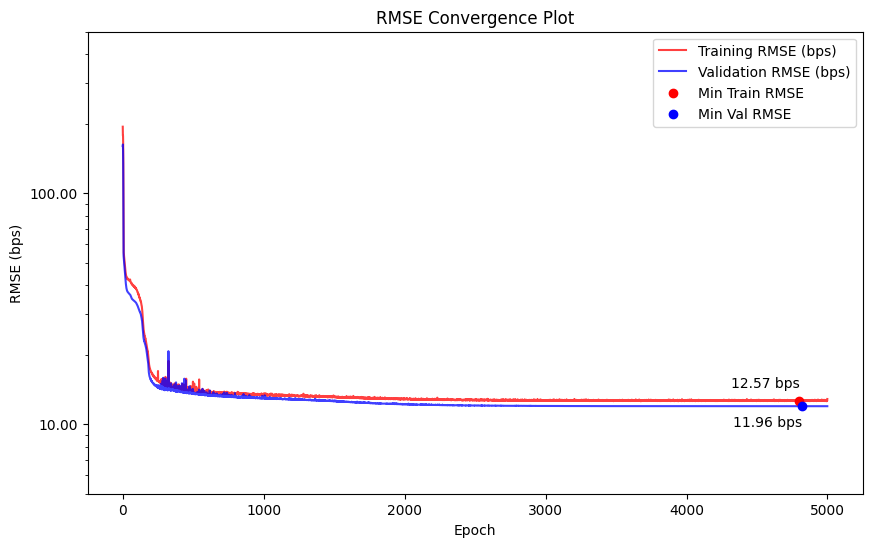

In [52]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Convert RMSE values to basis points (bps)
train_losses_bps = [loss * 10_000 for loss in train_losses]
val_losses_bps = [loss * 10_000 for loss in val_losses]

# Find min RMSE values in basis points and corresponding epochs
min_train_rmse_bps = min(train_losses_bps)
min_train_epoch = train_losses_bps.index(min_train_rmse_bps)

min_val_rmse_bps = min(val_losses_bps)
min_val_epoch = val_losses_bps.index(min_val_rmse_bps)

# Plot RMSE convergence
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses_bps, label='Training RMSE (bps)', alpha=0.75, color = "red")
plt.plot(range(epochs), val_losses_bps, label='Validation RMSE (bps)', alpha=0.75, color = "blue")

# Highlight min points
plt.scatter(min_train_epoch, min_train_rmse_bps, color='red', zorder=3, label='Min Train RMSE')
plt.scatter(min_val_epoch, min_val_rmse_bps, color='blue', zorder=3, label='Min Val RMSE')

# Annotate min points with their values in basis points
plt.text(min_train_epoch, min_train_rmse_bps + 1.5, f"{min_train_rmse_bps:.2f} bps", 
         verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='black')

plt.text(min_val_epoch, min_val_rmse_bps - 2.5, f"{min_val_rmse_bps:.2f} bps", 
         verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='black')

plt.xlabel('Epoch')
plt.ylabel('RMSE (bps)')
plt.yscale('log')  # Log-scale y-axis
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))
plt.title('RMSE Convergence Plot')
plt.ylim(5, 500)
plt.yticks([10, 100])
plt.legend()
plt.show()

In [55]:
import pandas as pd
import torch
import torch.nn as nn

# Load the saved weights
#model.load_state_dict(torch.load("best_fiae2_model.pt"))

# Set to evaluation mode if you are using the model for inference
model.eval()

# Load full data (already wide format)
data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])

# Filter for test data from 2023 and 2024
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()

# Define function to compute RMSE and Arbitrage Loss
def compute_metrics(model, data_tensor):
    model.eval()
    G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates = model(data_tensor)

    # Compute RMSE (Mean Squared Error)
    mse_loss = nn.MSELoss()(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], data_tensor)
    rmse = mse_loss.sqrt().item() * 10_000  # Convert to basis points (bps)

    return rmse

# Compute RMSE and Arbitrage Loss for each currency
currency_metrics = []
for currency in currencies.unique():
    currency_train_tensor = torch.tensor(
        train_df.loc[currencies == currency].values, dtype=torch.float32
    )
    currency_val_tensor = torch.tensor(
        val_df.loc[currencies == currency].values, dtype=torch.float32
    )
    currency_test_tensor = torch.tensor(
        test_df[test_df['Currency'] == currency].iloc[:, 2:].values, dtype=torch.float32
    )

    train_rmse = compute_metrics(model, currency_train_tensor)
    val_rmse = compute_metrics(model, currency_val_tensor)
    test_rmse = compute_metrics(model, currency_test_tensor)

    currency_metrics.append({
        "Currency": currency,
        "Train RMSE (bps)": train_rmse,
        "Validation RMSE (bps)": val_rmse,
        "Test RMSE (bps)": test_rmse
    })

# Convert to DataFrame
rmse_df = pd.DataFrame(currency_metrics)

# Add average row
average_train_rmse = rmse_df["Train RMSE (bps)"].mean()
average_val_rmse = rmse_df["Validation RMSE (bps)"].mean()

rmse_df.loc[len(rmse_df)] = [
    "Average",
    rmse_df["Train RMSE (bps)"].mean(),
    rmse_df["Validation RMSE (bps)"].mean(),
    rmse_df["Test RMSE (bps)"].mean()
]

# Print DataFrame
print(rmse_df.to_string(index=False))

Currency  Train RMSE (bps)  Validation RMSE (bps)  Test RMSE (bps)
     AUD         13.203738              10.564871        14.119826
     CAD         10.561254               8.953299        38.769869
     DKK         12.292524              10.260813        24.100768
     EUR         16.696001              18.054693        25.709325
     GBP         11.242985              11.642702              NaN
     JPY         14.234416              14.985460         6.662966
     NOK         10.693817              11.811842        32.367602
     SEK         11.154608              10.336312        27.031910
     USD         12.149690              10.887121        45.704539
 Average         12.469893              11.944124        26.808351


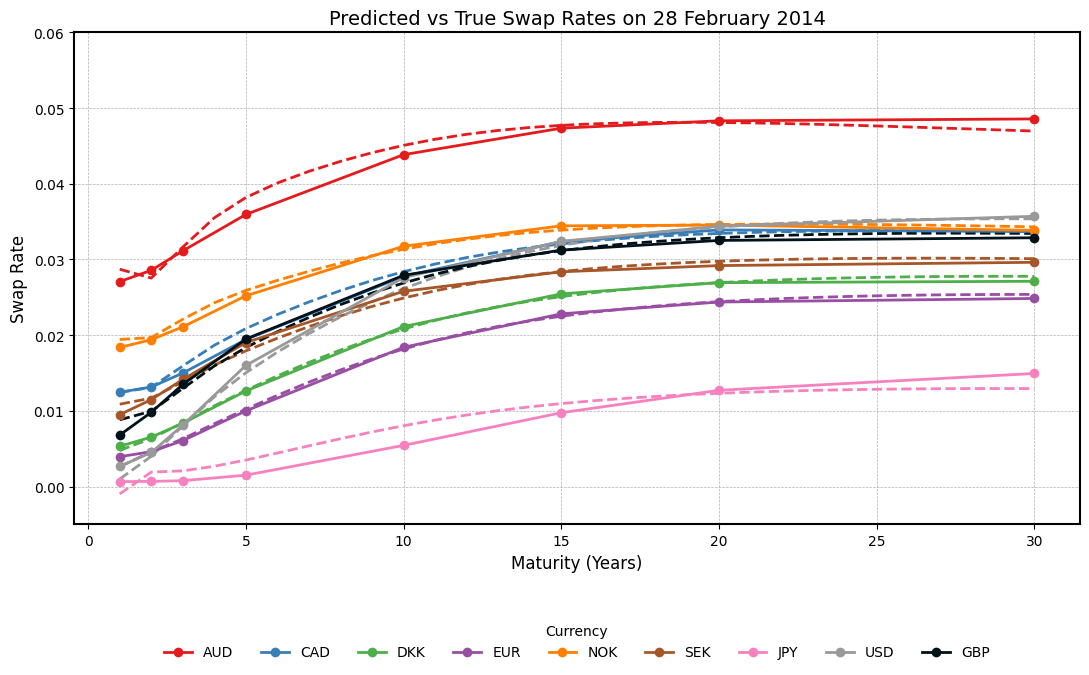

In [56]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Unpack train and validation tensors, dates, and currencies
train_tensor, train_dates_np, train_currencies_np = train_data_with_dates_currencies
val_tensor, val_dates_np, val_currencies_np = val_data_with_dates_currencies

# Filter for target date
target_date = np.datetime64("2014-02-28")
date_filter_train = train_dates_np == target_date
date_filter_val = val_dates_np == target_date

selected_train_data = train_tensor[date_filter_train]
selected_val_data = val_tensor[date_filter_val]

selected_train_currencies = train_currencies_np[date_filter_train]
selected_val_currencies = val_currencies_np[date_filter_val]

# Combine data
selected_data = torch.cat((selected_train_data, selected_val_data), dim=0)
selected_currencies = np.concatenate((selected_train_currencies, selected_val_currencies))

# Get predictions
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(selected_data)

# Define maturities
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

# --- Build long-format DataFrame ---
plot_data = []
for i, currency in enumerate(selected_currencies):
    true_row = selected_data[i].cpu().numpy()
    pred_row = swap_rates_pred[i]

    for m_idx, m in enumerate(selected_maturities):
        plot_data.append({"Maturity": m, "Rate": true_row[m_idx], "Currency": currency, "Type": "True"})
    for m in range(1, 31):
        plot_data.append({"Maturity": m, "Rate": pred_row[m-1].item(), "Currency": currency, "Type": "Predicted"})

df_plot = pd.DataFrame(plot_data)

# --- Set desired currency order and colors ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# --- Plot ---
plt.figure(figsize=(11, 7))

# Predicted (dashed lines)
sns.lineplot(
    data=df_plot[df_plot["Type"] == "Predicted"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    linestyle="--",
    legend=False
)

# True (solid lines with filled markers)
true_lines = sns.lineplot(
    data=df_plot[df_plot["Type"] == "True"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    marker='o'
)

# Customize true markers (bigger + filled)
for line in true_lines.lines:
    if line.get_marker() != 'None':
        line.set_markersize(7)
        line.set_markerfacecolor(line.get_color())
        line.set_markeredgewidth(0)

# Axis styling
plt.xticks(ticks=range(0, 31, 5))
plt.yticks(ticks=np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)

plt.title("Predicted vs True Swap Rates on 28 February 2014", fontsize=14, ha="center")
plt.xlabel("Maturity (Years)", fontsize=12)
plt.ylabel("Swap Rate", fontsize=12)

# Legend
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

# Grid and border styling
plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

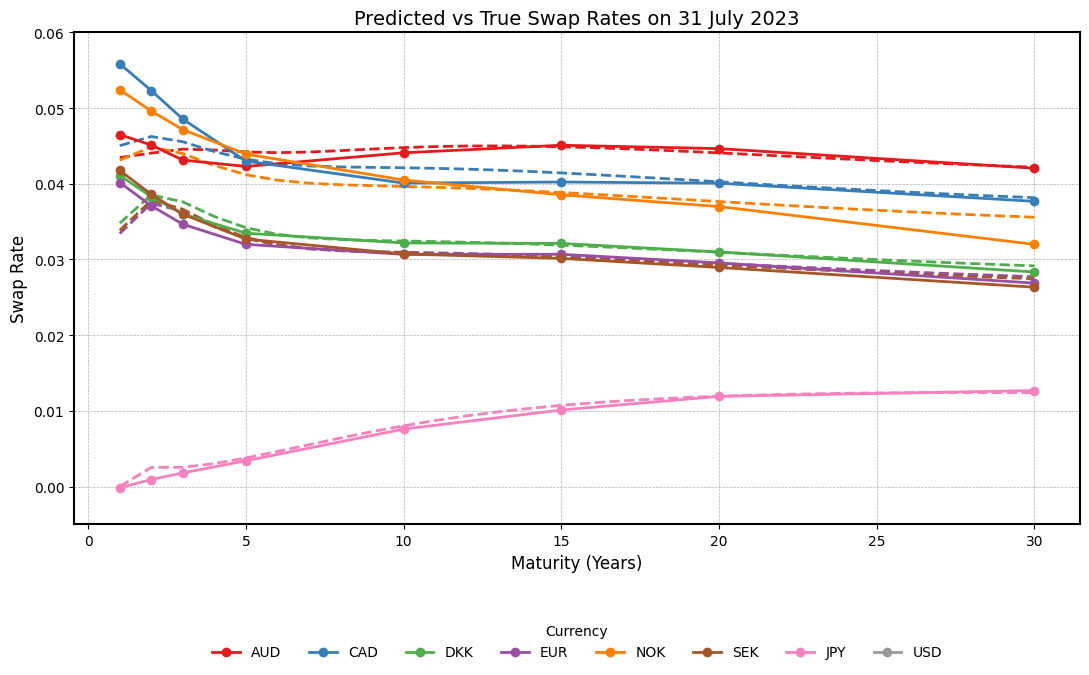

In [57]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load and filter data ---
plot_date = pd.to_datetime("2023-07-31")
data_full["Date"] = pd.to_datetime(data_full["Date"])
filtered_data = data_full[data_full["Date"] == plot_date].copy()

# Extract input swap rates and metadata
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
filtered_data_tensor = torch.tensor(filtered_data[maturity_cols].values, dtype=torch.float32)
filtered_currencies = filtered_data["Currency"].values

# --- Model predictions ---
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, predicted_swaps = model(filtered_data_tensor)

# --- Build long-form DataFrame ---
plot_data = []
for i, currency in enumerate(filtered_currencies):
    true_row = filtered_data_tensor[i].numpy()
    pred_row = predicted_swaps[i]
    for m_idx, (maturity, true_rate) in enumerate(zip(maturity_cols, true_row)):
        plot_data.append({"Maturity": int(maturity.rstrip("Y")), "Rate": true_rate, "Currency": currency, "Type": "True"})
    for m in range(1, 31):
        plot_data.append({"Maturity": m, "Rate": pred_row[m-1].item(), "Currency": currency, "Type": "Predicted"})

df_plot = pd.DataFrame(plot_data)

# --- Define custom order and palette ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', 'USD']
custom_palette = {
    'AUD': "#E41A1C",
    'CAD': "#377EB8",
    'DKK': "#4DAF4A",
    'EUR': "#984EA3",
    'NOK': "#FF7F00",
    'SEK': "#A65628",
    'JPY': "#F781BF",
    'USD': "#999999",  
}

# --- Plot ---
plt.figure(figsize=(11, 7))

# Predicted curves
sns.lineplot(
    data=df_plot[df_plot["Type"] == "Predicted"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    linestyle='--',
    legend=False
)

# Plot true swap rates (with larger, filled markers)
lineplot = sns.lineplot(
    data=df_plot[df_plot["Type"] == "True"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    marker='o'
)

# --- Remove white border & increase marker size ---
for line in lineplot.lines:
    if line.get_marker() != 'None':
        line.set_markersize(7)                     # Increase size
        line.set_markerfacecolor(line.get_color()) # Fill with line color
        line.set_markeredgewidth(0)                # Remove border


# Axis formatting
plt.xticks(ticks=range(0, 31, 5))
plt.yticks(ticks=np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)

# Labels and title
plt.title("Predicted vs True Swap Rates on 31 July 2023", fontsize=14, ha="center")
plt.xlabel("Maturity (Years)", fontsize=12)
plt.ylabel("Swap Rate", fontsize=12)

# Custom legend with desired order
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=8,
    frameon=False
)

# Grid and styling
plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

In [58]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

# Prepare 8 observed maturity positions
maturity_labels = [1, 2, 3, 5, 10, 15, 20, 30]
selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]

# Function to compute RMSE per maturity for a given tensor
def compute_rmse_per_maturity(model, data_tensor):
    model.eval()
    G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates = model(data_tensor)
    swap_rates_selected = swap_rates[:, selected_indices]

    mse_per_maturity = torch.mean((swap_rates_selected - data_tensor) ** 2, dim=0)
    rmse_per_maturity = torch.sqrt(mse_per_maturity) * 10_000  # Convert to bps
    return rmse_per_maturity.cpu().detach().numpy()

# Compute per-maturity RMSEs
rmse_train = compute_rmse_per_maturity(model, train_tensor)
rmse_val   = compute_rmse_per_maturity(model, val_tensor)

# Prepare test data
data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()
test_tensor = torch.tensor(test_df.iloc[:, 2:].values, dtype=torch.float32)
rmse_test = compute_rmse_per_maturity(model, test_tensor)

# Create DataFrame
rmse_by_maturity = pd.DataFrame({
    "Maturity (Years)": maturity_labels,
    "Train RMSE (bps)": rmse_train,
    "Validation RMSE (bps)": rmse_val,
    "Test RMSE (bps)": rmse_test
})

rmse_by_maturity

Maturity (Years)  Train RMSE (bps)  Validation RMSE (bps)  Test RMSE (bps)
0                 1         19.342157              16.505991        68.002113
1                 2         13.794417              14.402693        22.132553
2                 3         13.724249              13.846785        20.969196
3                 5         14.900196              14.802471        15.507429
4                10          9.680569               9.244139         9.936951
5                15          5.885087               6.379089         5.924552
6                20          6.485252               7.882854         4.820414
7                30         11.594807              11.209660        12.102617

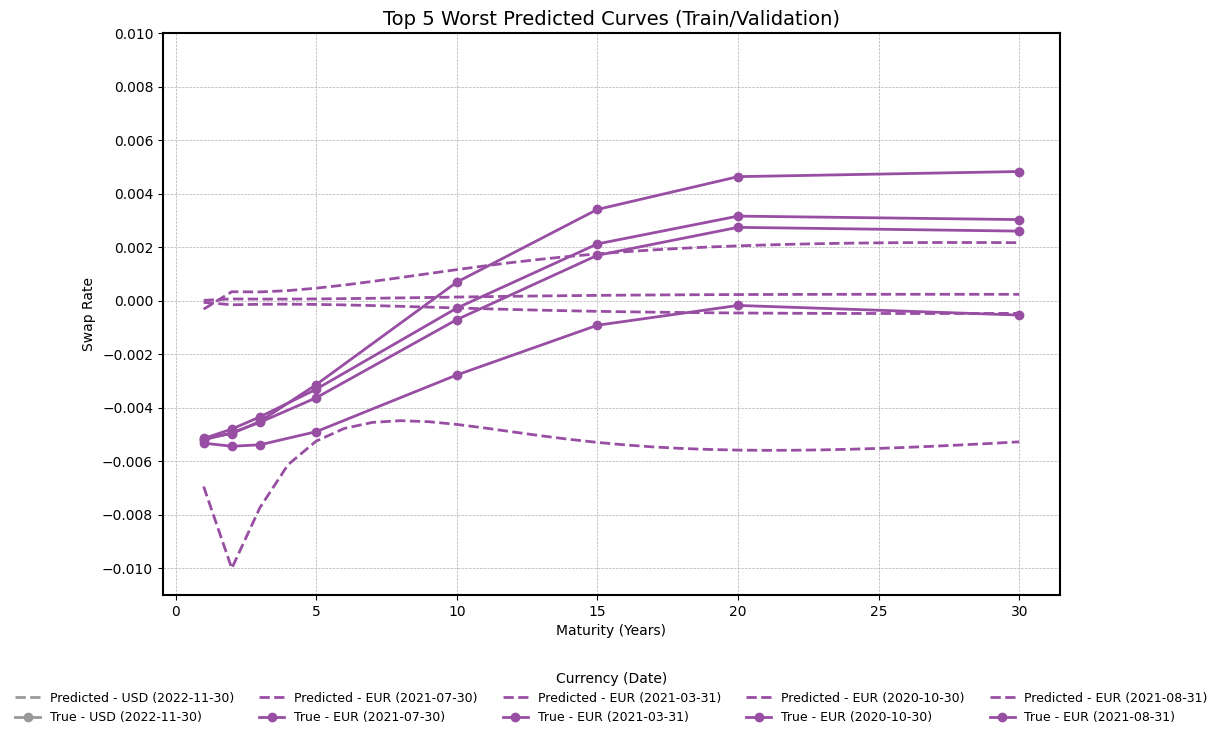

In [61]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

# Define distinct marker styles
marker_styles = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '<', '>']

# --- Setup ---
selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}
fallback_color = "#000000"

# Combine train + validation
train_val_tensor = torch.cat((train_tensor, val_tensor), dim=0)
train_val_dates = np.concatenate((train_dates_np, val_dates_np))
train_val_currencies = np.concatenate((train_currencies_np, val_currencies_np))

# --- Model Prediction ---
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(train_val_tensor)
selected_pred = swap_rates_pred[:, selected_indices]
rmse_per_curve = torch.sqrt(torch.mean((selected_pred - train_val_tensor) ** 2, dim=1))

# --- Top 10 worst curves ---
worst_indices = torch.topk(rmse_per_curve, 5).indices.cpu().numpy()

# --- Plot ---
plt.figure(figsize=(12, 8))

for idx in worst_indices:
    currency = train_val_currencies[idx]
    date = pd.to_datetime(train_val_dates[idx]).strftime('%Y-%m-%d')
    color = custom_palette.get(currency, fallback_color)
    label = f"{currency} ({date})"

    true_curve = train_val_tensor[idx].numpy()
    pred_curve = swap_rates_pred[idx].cpu().detach().numpy()

    plt.plot(full_maturities, pred_curve, linestyle="--", linewidth=2, color=color, label=f"Predicted - {label}")
    plt.plot(selected_maturities, true_curve, marker='o', linewidth=2, color=color, label=f"True - {label}")
    # Annotate last point (30Y) of true curve
    #plt.text(
    #    x=selected_maturities[-1] + 0.4,
    #    y=true_curve[-1],
    #    s=label,
     #   fontsize=9,
    #    color=color,
    #    verticalalignment='center'
    #)


# --- Formatting ---
plt.title("Top 5 Worst Predicted Curves (Train/Validation)", fontsize=14)
plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.xticks(range(0, 31, 5))
plt.yticks(np.arange(-0.01, 0.061, 0.002))
plt.ylim(-0.011, 0.01)
plt.grid(True, linestyle="--", linewidth=0.5)

for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

# --- Legend below plot ---
plt.legend(
    title="Currency (Date)",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=5,  # You can set this to 9 if each label is short, but 2–3 is often clearer
    frameon=False,
    fontsize=9,
    title_fontsize=10
)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Add this line to shift plot up for legend space
plt.show()

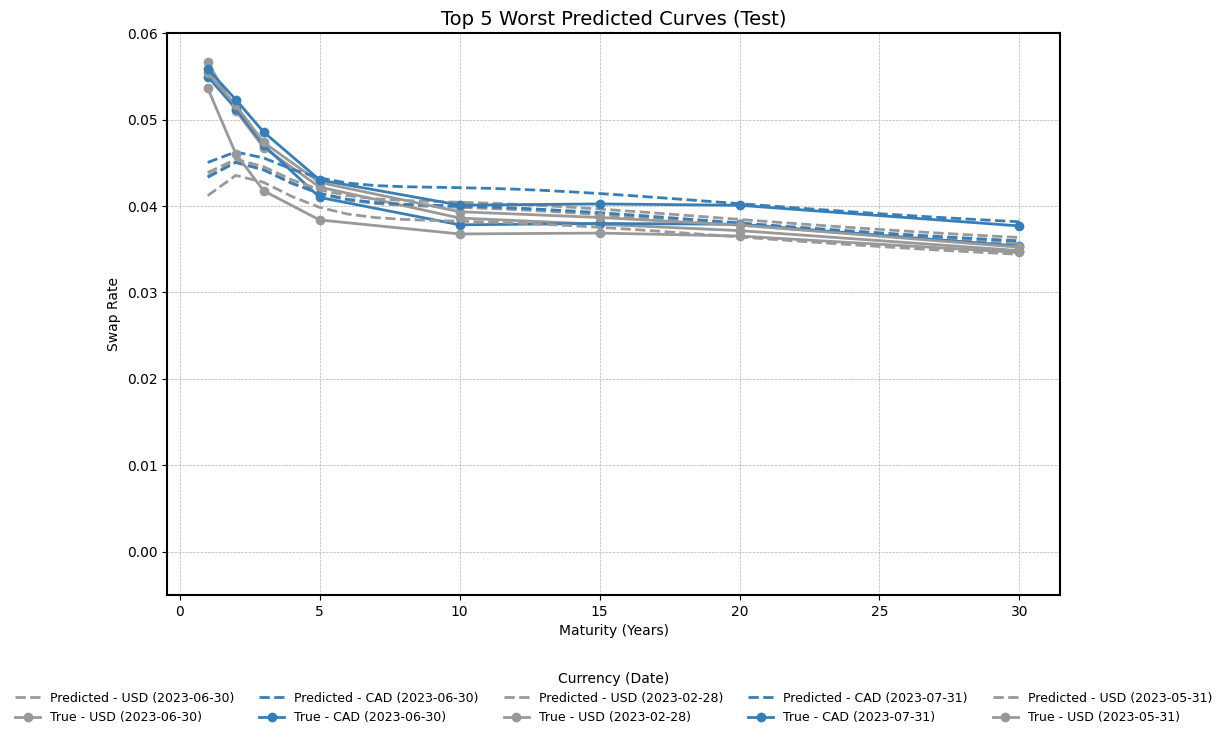

In [62]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- Prepare test data ---
data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()
test_tensor = torch.tensor(test_df.iloc[:, 2:].values, dtype=torch.float32)
test_currencies = test_df["Currency"].values
test_dates = test_df["Date"].values

# --- Setup ---
selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}
fallback_color = "#000000"

# --- Model Prediction ---
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(test_tensor)
selected_pred = swap_rates_pred[:, selected_indices]
rmse_per_curve = torch.sqrt(torch.mean((selected_pred - test_tensor) ** 2, dim=1))

# --- Top 5 worst curves ---
worst_indices = torch.topk(rmse_per_curve, 5).indices.cpu().numpy()

# --- Plot ---
plt.figure(figsize=(12, 8))

for idx in worst_indices:
    currency = test_currencies[idx]
    date = pd.to_datetime(test_dates[idx]).strftime('%Y-%m-%d')
    color = custom_palette.get(currency, fallback_color)
    label = f"{currency} ({date})"

    true_curve = test_tensor[idx].numpy()
    pred_curve = swap_rates_pred[idx].cpu().detach().numpy()

    plt.plot(full_maturities, pred_curve, linestyle="--", linewidth=2, color=color, label=f"Predicted - {label}")
    plt.plot(selected_maturities, true_curve, marker='o', linewidth=2, color=color, label=f"True - {label}")

# --- Formatting ---
plt.title("Top 5 Worst Predicted Curves (Test)", fontsize=14)
plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.xticks(range(0, 31, 5))
plt.yticks(np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)
plt.grid(True, linestyle="--", linewidth=0.5)

for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

# --- Legend below plot ---
plt.legend(
    title="Currency (Date)",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=5,
    frameon=False,
    fontsize=9,
    title_fontsize=10
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

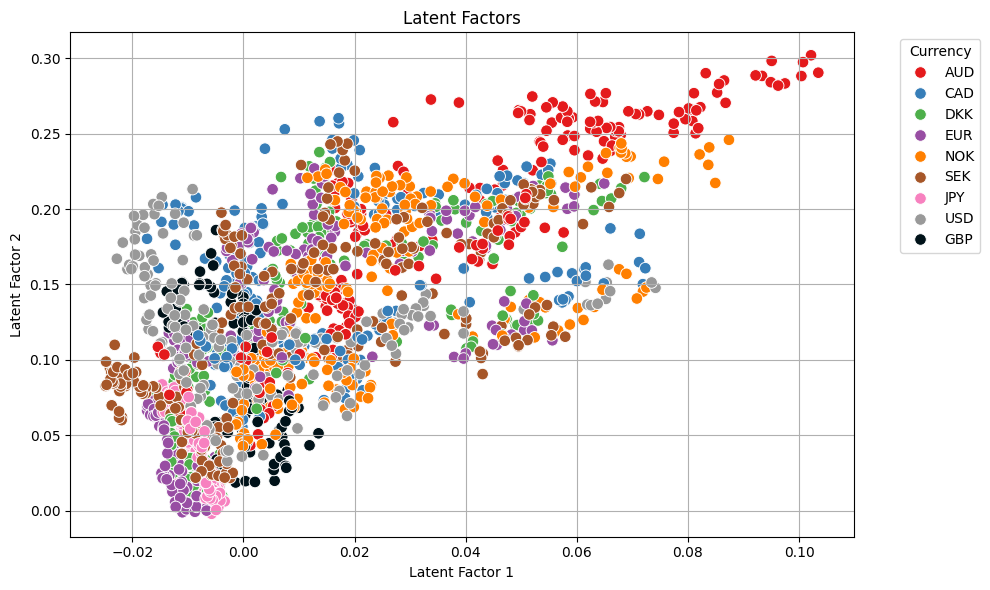

In [63]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']

# Split into sets
train_df = data_full[data_full["Date"].dt.year <= 2018].copy()
val_df = data_full[(data_full["Date"].dt.year > 2018) & (data_full["Date"].dt.year < 2023)].copy()
test_df = data_full[data_full["Date"].dt.year >= 2023].copy()

# Add labels
train_df["Set"] = "Train"
val_df["Set"] = "Validation"
test_df["Set"] = "Test"
combined_df = pd.concat([train_df, val_df, test_df])

# Prepare tensors
data_tensor = torch.tensor(combined_df[maturity_cols].values, dtype=torch.float32)
currencies = combined_df["Currency"].values
sets = combined_df["Set"].values

# Run model to get latent variables
#model.load_state_dict(torch.load("best_fiae2_model_final.pt"))
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(data_tensor)

# Define palette and order
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# Create DataFrame for plotting
latent_df = pd.DataFrame({
    "Latent_1": z[:, 0].detach().numpy(),
    "Latent_2": z[:, 1].detach().numpy(),
    "Currency": currencies,
    "Set": sets
})

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=latent_df,
    x="Latent_1", y="Latent_2",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    s=70
)
plt.title("Latent Factors")
plt.xlabel("Latent Factor 1")
plt.ylabel("Latent Factor 2")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Currency")
plt.tight_layout()
plt.show()

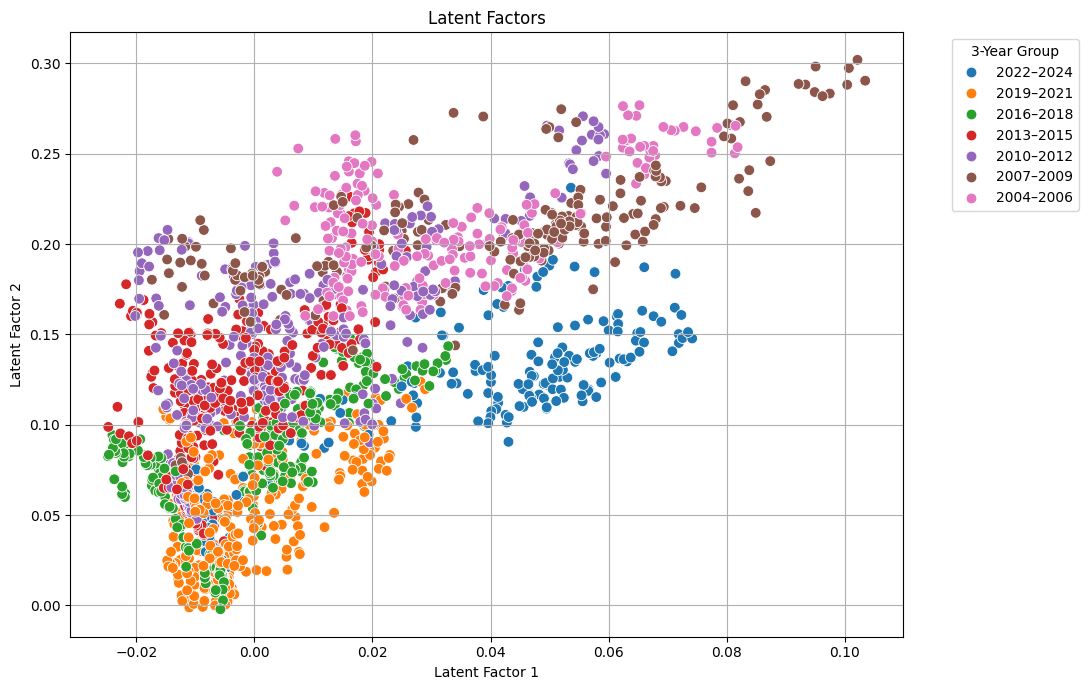

In [64]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year

# Filter to years 2004 to 2024
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# 🟢 Create 3-year grouping with label like "2004–2006"
def label_year_group(year):
    base = (year - 2004) // 3 * 3 + 2004
    return f"{base}–{base+2}"

data_filtered["YearGroup"] = data_filtered["Year"].apply(label_year_group)

# Prepare input tensor
data_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
currencies = data_filtered["Currency"].values
year_groups = data_filtered["YearGroup"].values

# Run model
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(data_tensor)

# Build dataframe for plotting
latent_df = pd.DataFrame({
    "Latent_1": z[:, 0].detach().numpy(),
    "Latent_2": z[:, 1].detach().numpy(),
    "Currency": currencies,
    "YearGroup": year_groups
})

# Plot
plt.figure(figsize=(11, 7))
sns.scatterplot(
    data=latent_df, x="Latent_1", y="Latent_2",
    hue="YearGroup", palette="tab10", s=60
)
plt.title("Latent Factors")
plt.xlabel("Latent Factor 1")
plt.ylabel("Latent Factor 2")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="3-Year Group")
plt.tight_layout()
plt.show()

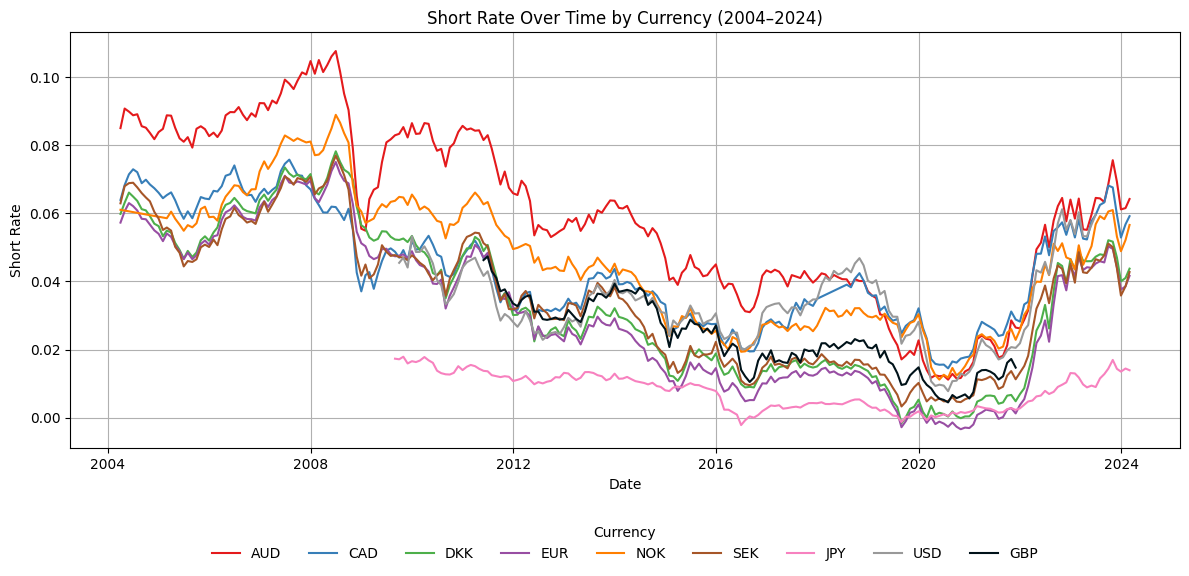

In [65]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define palette and order ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# --- Load and prepare data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Extract swap rate tensor and metadata ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Run through model ---
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(x_tensor)
short_rates = risk_neutral_rate[:, 0].cpu().detach().numpy()

# --- Build DataFrame ---
df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "RiskNeutralRate": short_rates
})

# --- Plot ---
plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="RiskNeutralRate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title("Short Rate Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel("Short Rate")
plt.grid(True)

# Legend below the plot
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

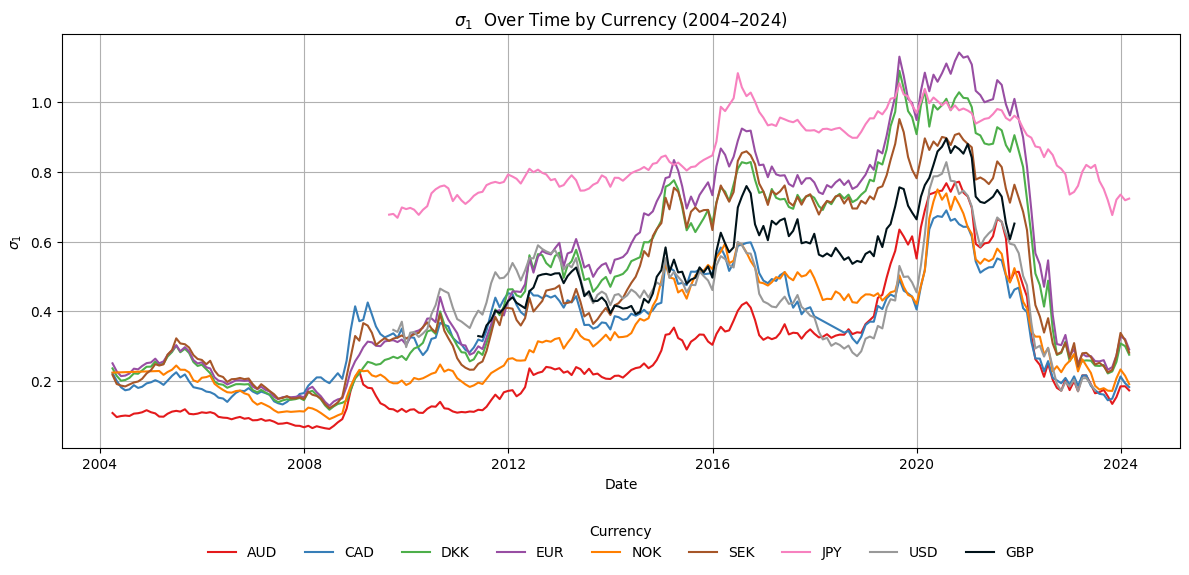

In [66]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define palette and order ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# --- Load and prepare data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Extract swap rate tensor and metadata ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Run through model ---
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(x_tensor)
sigma1_at_short_maturity = sigma1[:, 0].detach().cpu().numpy()

# --- Build DataFrame ---
df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": sigma1_at_short_maturity
})

# --- Plot ---
plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\sigma_1$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\sigma_1$ ")
plt.grid(True)

# Legend below the plot
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

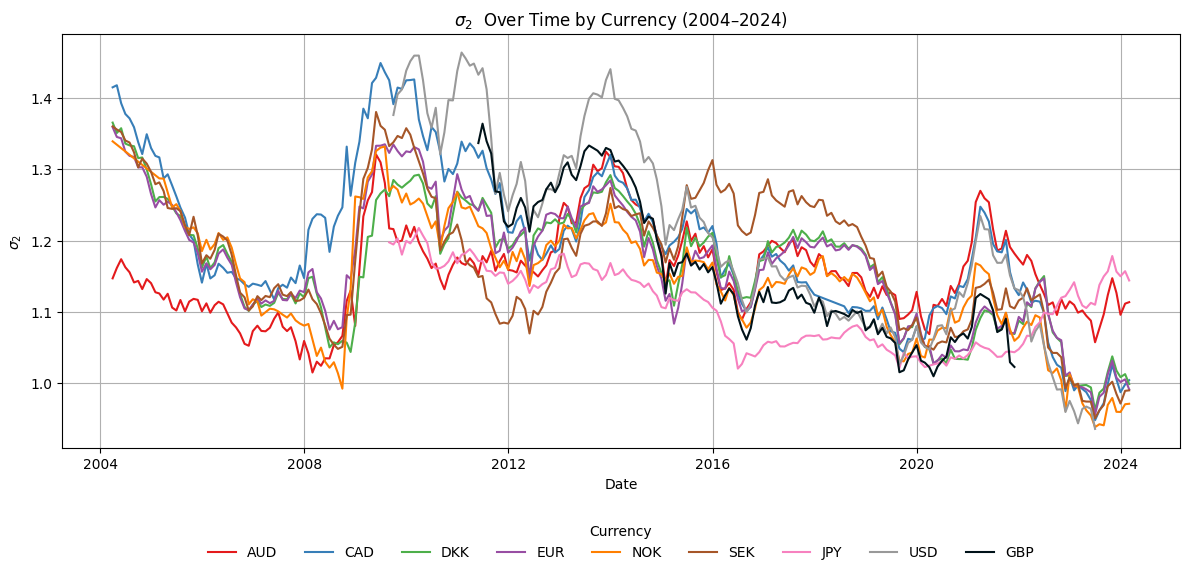

In [67]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define palette and order ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# --- Load and prepare data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Extract swap rate tensor and metadata ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Run through model ---
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(x_tensor)
sigma2_at_short_maturity = sigma2[:, 0].detach().cpu().numpy()

# --- Build DataFrame ---
df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_2": sigma2_at_short_maturity
})

# --- Plot ---
plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_2",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\sigma_2$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\sigma_2$ ")
plt.grid(True)

# Legend below the plot
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

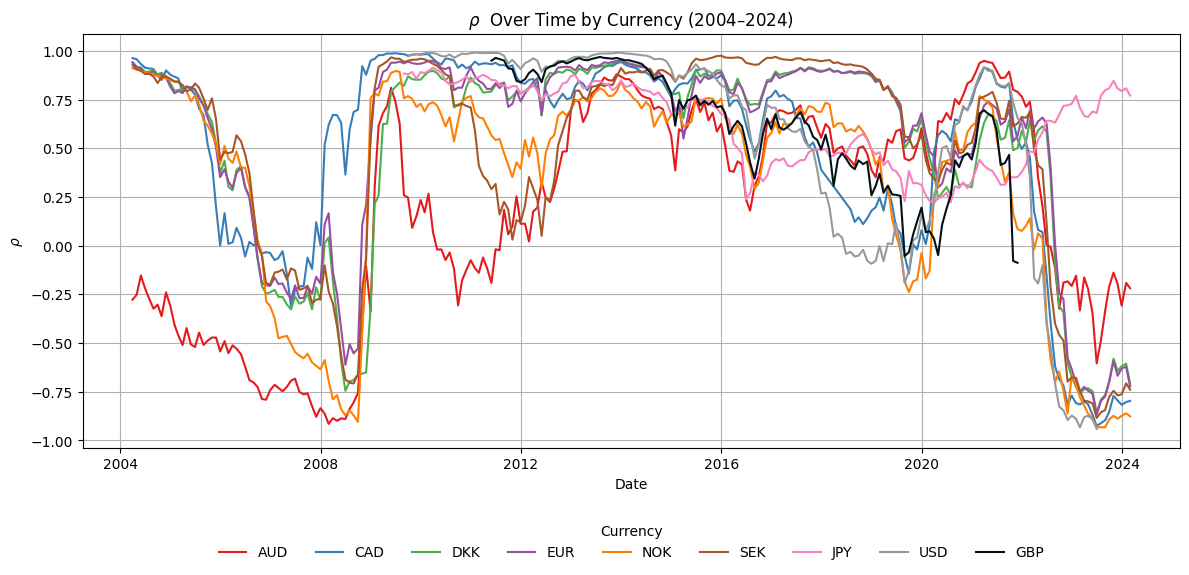

In [68]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define palette and order ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# --- Load and prepare data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Extract swap rate tensor and metadata ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Run through model ---
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(x_tensor)
rho = rho1[:, 0].detach().cpu().numpy()

# --- Build DataFrame ---
df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "rho": rho
})

# --- Plot ---
plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="rho",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\rho$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\rho$ ")
plt.grid(True)

# Legend below the plot
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

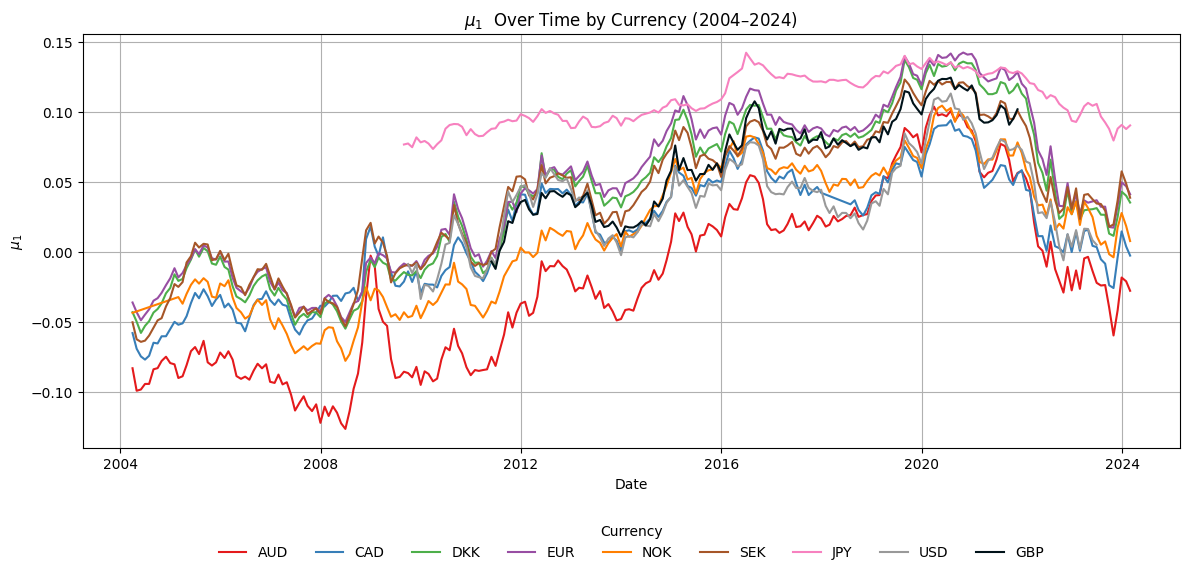

In [69]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define palette and order ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# --- Load and prepare data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Extract swap rate tensor and metadata ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Run through model ---
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(x_tensor)
mu1 = mu[:, 0, 0].detach().cpu().numpy()

# --- Build DataFrame ---
df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

# --- Plot ---
plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\mu_1$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\mu_1$ ")
plt.grid(True)

# Legend below the plot
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

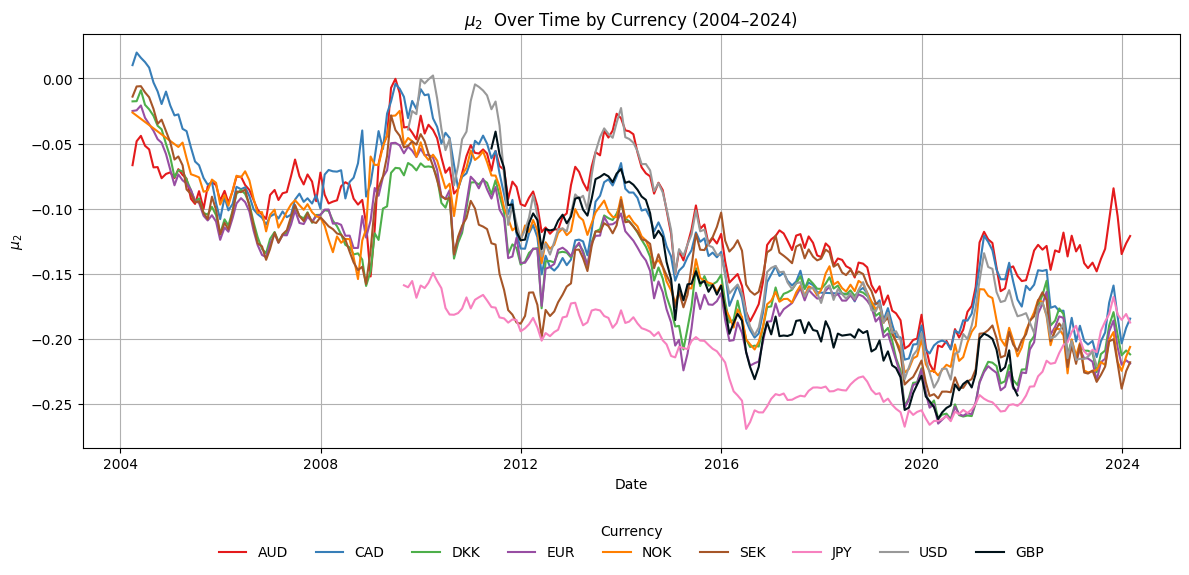

In [70]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define palette and order ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# --- Load and prepare data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Extract swap rate tensor and metadata ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Run through model ---
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(x_tensor)
mu1 = mu[:, 0, 1].detach().cpu().numpy()

# --- Build DataFrame ---
df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

# --- Plot ---
plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\mu_2$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\mu_2$ ")
plt.grid(True)

# Legend below the plot
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

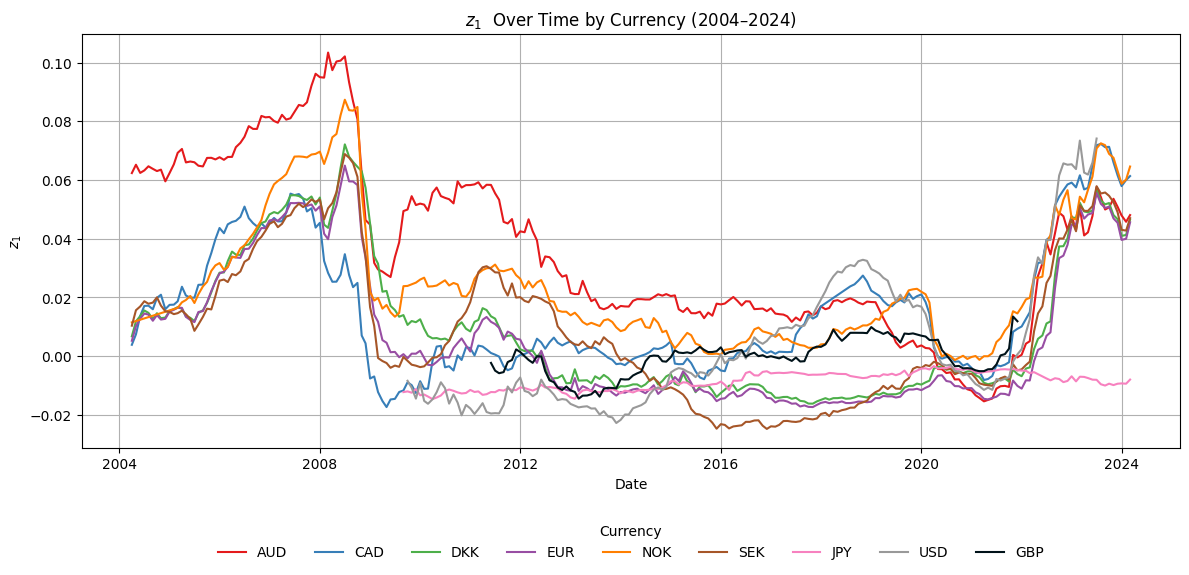

In [71]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define palette and order ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# --- Load and prepare data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Extract swap rate tensor and metadata ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Run through model ---
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(x_tensor)
mu1 = z[:, 0].detach().cpu().numpy()

# --- Build DataFrame ---
df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

# --- Plot ---
plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$z_1$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$z_1$ ")
plt.grid(True)

# Legend below the plot
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

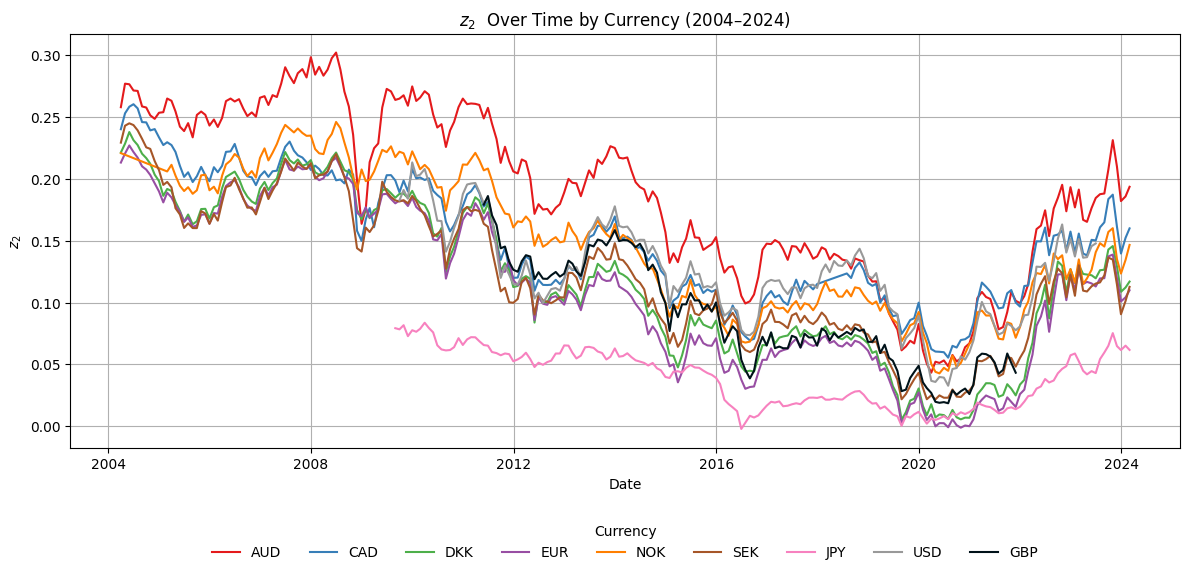

In [72]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define palette and order ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# --- Load and prepare data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Extract swap rate tensor and metadata ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Run through model ---
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(x_tensor)
mu1 = z[:, 1].detach().cpu().numpy()

# --- Build DataFrame ---
df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

# --- Plot ---
plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$z_2$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$z_2$ ")
plt.grid(True)

# Legend below the plot
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

In [73]:
# Switch to eval mode
model.eval()

# Forward pass on all training data
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, predicted_swaps = model(train_tensor)

# α, β, γ computation
sigma_H_sigma = torch.matmul(sigma_matrix.transpose(-1, -2), torch.matmul(hessian, sigma_matrix))
trace_sigma_H_sigma = sigma_H_sigma[..., 0, 0] + sigma_H_sigma[..., 1, 1]
alpha = (- gradients_maturities + torch.sum(gradients_latent * mu, dim=2) + 0.5 * trace_sigma_H_sigma) / G_out
beta = risk_neutral_rate / G_out

sigma_grad_outer = torch.matmul(gradients_latent.unsqueeze(-1), gradients_latent.unsqueeze(-2))
gamma_matrix = torch.matmul(sigma_matrix.transpose(-1, -2), torch.matmul(sigma_grad_outer, sigma_matrix))
gamma = 0.5 * (gamma_matrix[..., 0, 0] + gamma_matrix[..., 1, 1])

# B and A
zero_mask = (alpha.abs() < 1e-11)
B_z = beta * maturities
B_nz = (beta / alpha) * (torch.exp(alpha * maturities) - 1)
B = torch.where(zero_mask, B_z, B_nz)
A = gamma * (B ** 2) * maturities
gammaB2 = gamma * B ** 2

# Save to disk (optional)
#torch.save({'alpha': alpha.cpu(), 'beta': beta.cpu(), 'gamma': gamma.cpu(),
#            'B': B.cpu(), 'A': A.cpu(), 'gammaB2': gammaB2.cpu()}, "train_ode_components.pt")

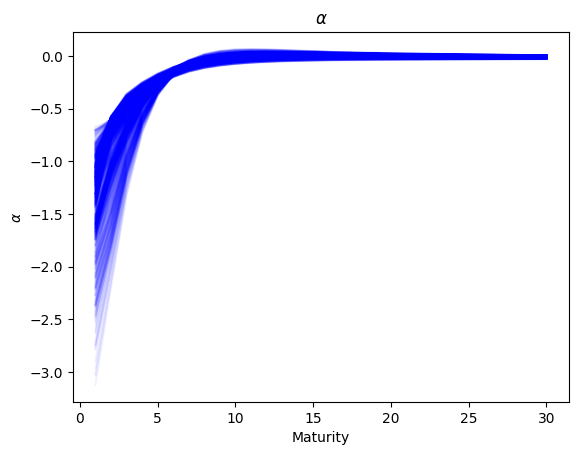

In [74]:
import torch
import matplotlib.pyplot as plt

# Load saved values
#components = torch.load("train_ode_components.pt")
##alpha = components["alpha"]
#beta = components["beta"]
#gamma = components["gamma"]
#B = components["B"]
#A = components["A"]
#gammaB2 = components["gammaB2"]

# Plot example: alpha row-wise
for i in range(alpha.shape[0]):
    plt.plot(range(1, 31), alpha.detach()[i], alpha=0.05, color="blue")
plt.title(r"$\alpha$")
plt.xlabel("Maturity")
plt.ylabel(r"$\alpha$")
plt.show()

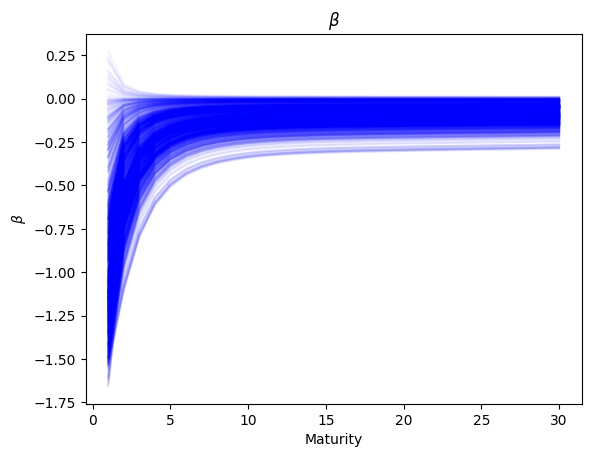

In [75]:
# Plot example: alpha row-wise
for i in range(beta.shape[0]):
    plt.plot(range(1, 31), beta.detach()[i], alpha=0.05, color="blue")
plt.title(r"$\beta$")
plt.xlabel("Maturity")
plt.ylabel(r"$\beta$")
plt.show()

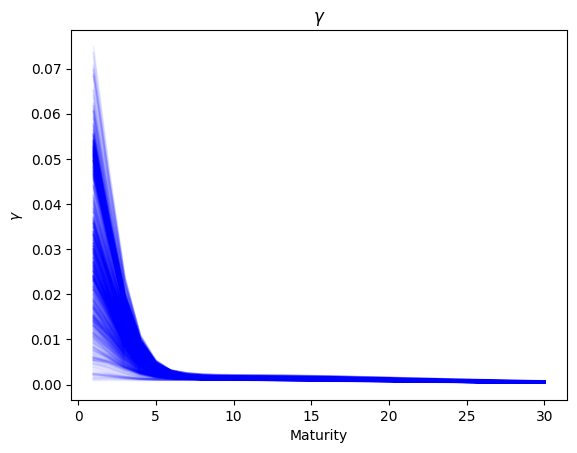

In [76]:
# Plot example: alpha row-wise
for i in range(gamma.shape[0]):
    plt.plot(range(1, 31), gamma.detach()[i], alpha=0.05, color="blue")
plt.title(r"$\gamma$")
plt.xlabel("Maturity")
plt.ylabel(r"$\gamma$")
plt.show()

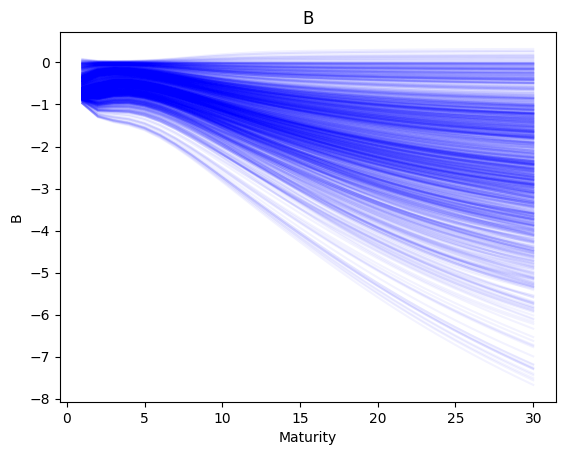

In [77]:
# Plot example: alpha row-wise
for i in range(B.shape[0]):
    plt.plot(range(1, 31), B.detach()[i], alpha=0.05, color="blue")
plt.title("B")
plt.xlabel("Maturity")
plt.ylabel("B")
plt.show()

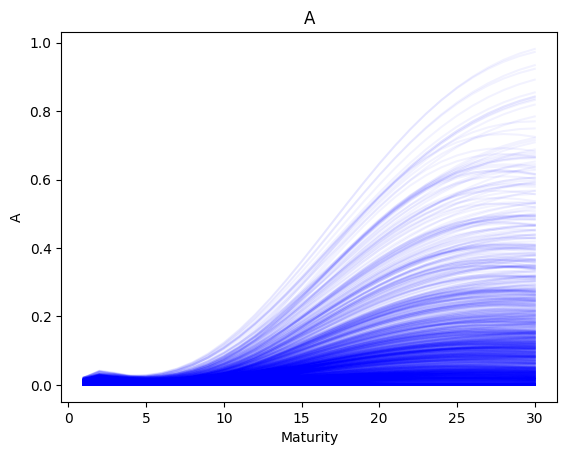

In [78]:
# Plot example: alpha row-wise
for i in range(A.shape[0]):
    plt.plot(range(1, 31), A.detach()[i], alpha=0.05, color="blue")
plt.title("A")
plt.xlabel("Maturity")
plt.ylabel("A")
plt.show()

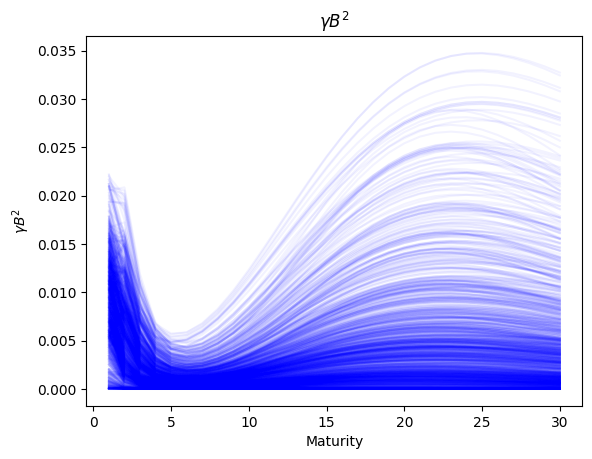

In [79]:
# Plot example: alpha row-wise
for i in range(gammaB2.shape[0]):
    plt.plot(range(1, 31), gammaB2.detach()[i], alpha=0.05, color="blue")
plt.title(r"$\gamma B^2$")
plt.xlabel("Maturity")
plt.ylabel(r"$\gamma B^2$")
plt.show()

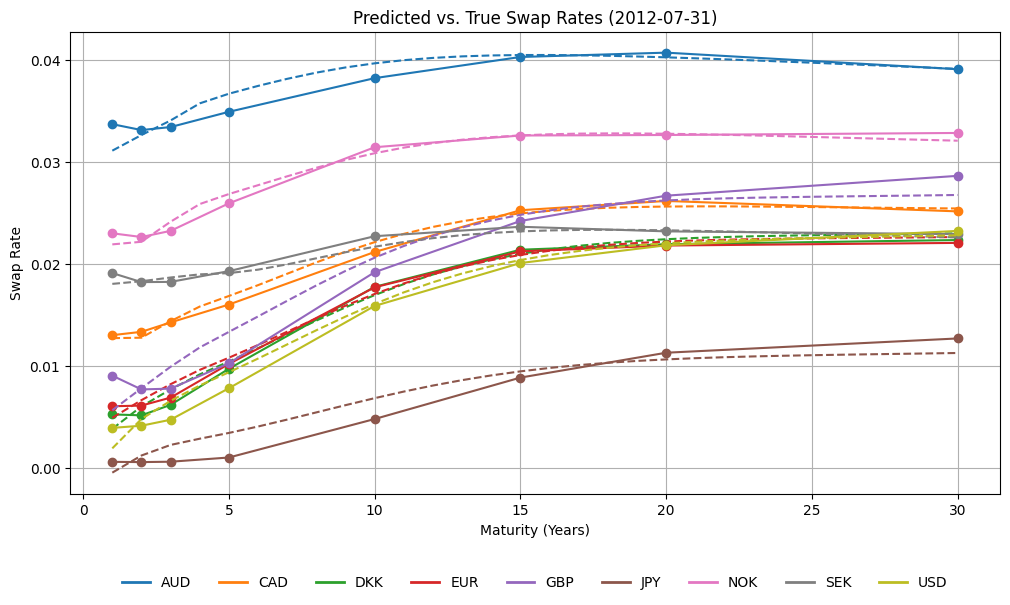

In [74]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Unpack train and validation tensors, dates, and currencies
train_tensor, train_dates_np, train_currencies_np = train_data_with_dates_currencies
val_tensor, val_dates_np, val_currencies_np = val_data_with_dates_currencies

# Select data from 2012-07-31
date_filter_train = train_dates_np == np.datetime64("2012-07-31")
date_filter_val = val_dates_np == np.datetime64("2012-07-31")

selected_train_data = train_tensor[date_filter_train]
selected_val_data = val_tensor[date_filter_val]

selected_train_currencies = train_currencies_np[date_filter_train]
selected_val_currencies = val_currencies_np[date_filter_val]

# Combine train and validation data
selected_data = torch.cat((selected_train_data, selected_val_data), dim=0)
selected_currencies = np.concatenate((selected_train_currencies, selected_val_currencies))

# Get model predictions
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(selected_data)

# Extract true swap rates (only for 8 maturities)
true_swap_rates = selected_data

# Define maturities
full_maturities = torch.arange(1, 31).cpu()  # Full 30 maturities for predicted rates
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]  # 8 maturities for true swap rates

# Get unique currencies for plotting
plt.figure(figsize=(12, 6))

color_map = {}
colors = plt.cm.tab10.colors  # Get distinct colors for different currencies

for idx, currency in enumerate(np.unique(selected_currencies)):
    color_map[currency] = colors[idx % len(colors)]  # Assign colors per currency
    
    # Get indices of this currency's data
    currency_indices = np.where(selected_currencies == currency)[0]
    
    if len(currency_indices) > 0:  # Ensure there is data for this currency
        for i in currency_indices:
            # Plot true swap rates (only for 8 selected maturities) as a solid line
            plt.plot(selected_maturities, true_swap_rates[i].cpu(), color=color_map[currency], linestyle='solid', marker='o')

            # Plot predicted swap rates (for all 30 maturities) as a dashed line
            plt.plot(full_maturities, swap_rates_pred[i].detach().cpu().numpy(), color=color_map[currency], linestyle='dashed')

plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.title("Predicted vs. True Swap Rates (2012-07-31)")

# Create legend to only show currency colors
legend_handles = [plt.Line2D([0], [0], color=color_map[currency], lw=2, label=currency) for currency in color_map]
plt.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=min(len(color_map), 9), fontsize=10, frameon=False)

plt.grid()
plt.show()

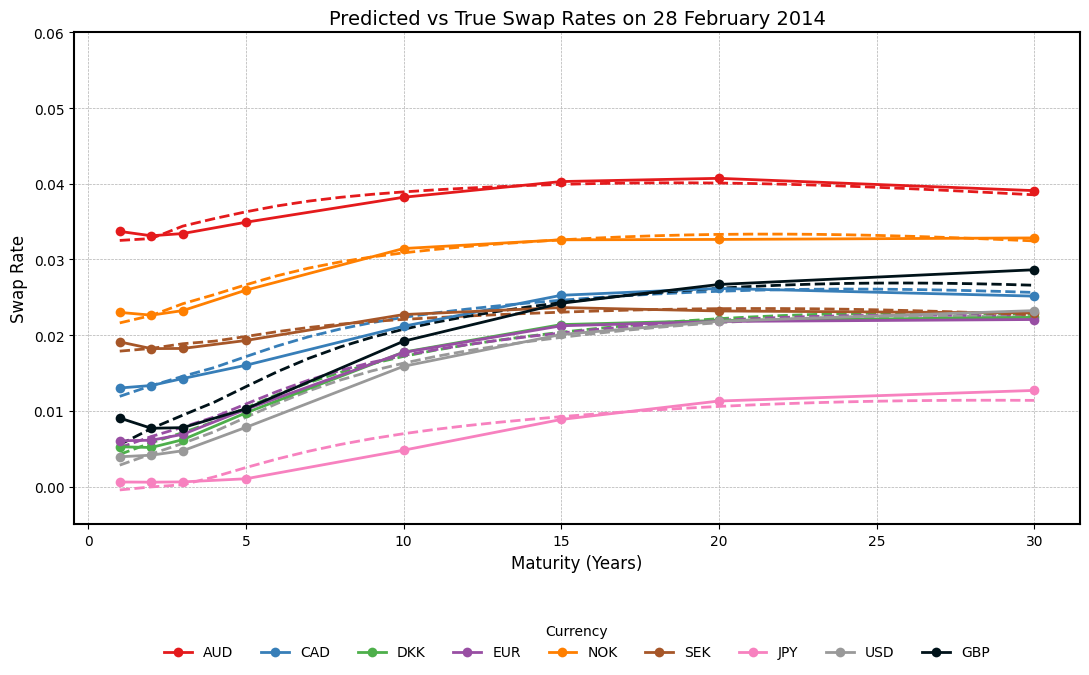

In [24]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Unpack train and validation tensors, dates, and currencies
train_tensor, train_dates_np, train_currencies_np = train_data_with_dates_currencies
val_tensor, val_dates_np, val_currencies_np = val_data_with_dates_currencies

# Filter for target date
target_date = np.datetime64("2012-07-31")
date_filter_train = train_dates_np == target_date
date_filter_val = val_dates_np == target_date

selected_train_data = train_tensor[date_filter_train]
selected_val_data = val_tensor[date_filter_val]

selected_train_currencies = train_currencies_np[date_filter_train]
selected_val_currencies = val_currencies_np[date_filter_val]

# Combine data
selected_data = torch.cat((selected_train_data, selected_val_data), dim=0)
selected_currencies = np.concatenate((selected_train_currencies, selected_val_currencies))

# Get predictions
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(selected_data)

# Define maturities
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

# --- Build long-format DataFrame ---
plot_data = []
for i, currency in enumerate(selected_currencies):
    true_row = selected_data[i].cpu().numpy()
    pred_row = swap_rates_pred[i]

    for m_idx, m in enumerate(selected_maturities):
        plot_data.append({"Maturity": m, "Rate": true_row[m_idx], "Currency": currency, "Type": "True"})
    for m in range(1, 31):
        plot_data.append({"Maturity": m, "Rate": pred_row[m-1].item(), "Currency": currency, "Type": "Predicted"})

df_plot = pd.DataFrame(plot_data)

# --- Set desired currency order and colors ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# --- Plot ---
plt.figure(figsize=(11, 7))

# Predicted (dashed lines)
sns.lineplot(
    data=df_plot[df_plot["Type"] == "Predicted"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    linestyle="--",
    legend=False
)

# True (solid lines with filled markers)
true_lines = sns.lineplot(
    data=df_plot[df_plot["Type"] == "True"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    marker='o'
)

# Customize true markers (bigger + filled)
for line in true_lines.lines:
    if line.get_marker() != 'None':
        line.set_markersize(7)
        line.set_markerfacecolor(line.get_color())
        line.set_markeredgewidth(0)

# Axis styling
plt.xticks(ticks=range(0, 31, 5))
plt.yticks(ticks=np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)

plt.title("Predicted vs True Swap Rates on 28 February 2014", fontsize=14, ha="center")
plt.xlabel("Maturity (Years)", fontsize=12)
plt.ylabel("Swap Rate", fontsize=12)

# Legend
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

# Grid and border styling
plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

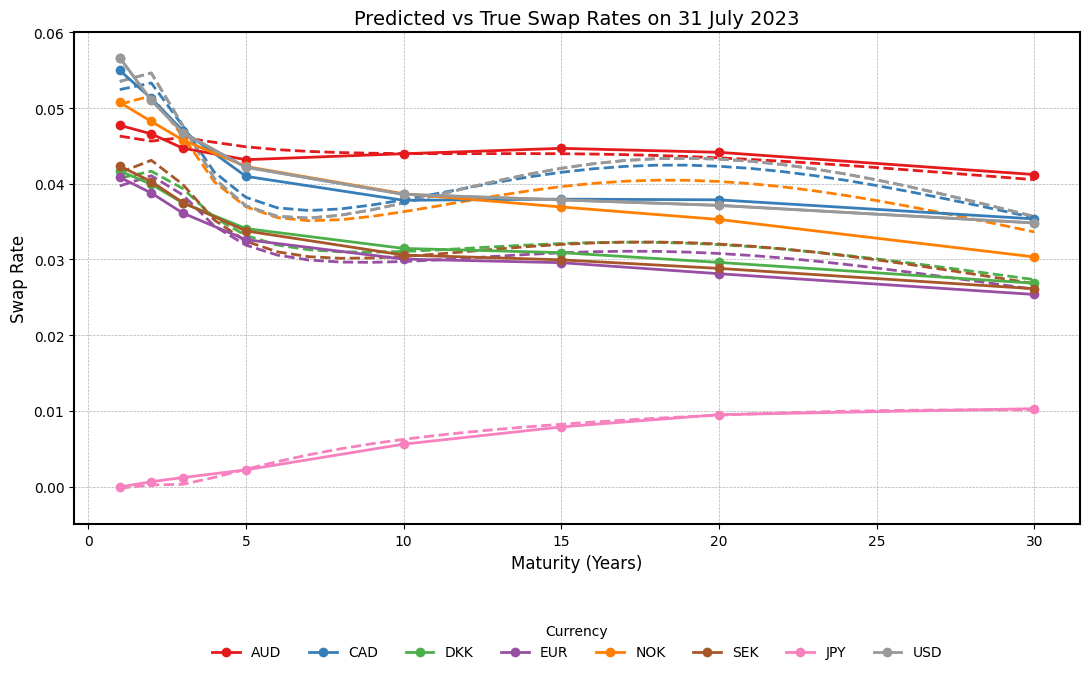

In [25]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load and filter data ---
plot_date = pd.to_datetime("2023-06-30")
data_full["Date"] = pd.to_datetime(data_full["Date"])
filtered_data = data_full[data_full["Date"] == plot_date].copy()

# Extract input swap rates and metadata
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
filtered_data_tensor = torch.tensor(filtered_data[maturity_cols].values, dtype=torch.float32)
filtered_currencies = filtered_data["Currency"].values

# --- Model predictions ---
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, predicted_swaps = model(filtered_data_tensor)

# --- Build long-form DataFrame ---
plot_data = []
for i, currency in enumerate(filtered_currencies):
    true_row = filtered_data_tensor[i].numpy()
    pred_row = predicted_swaps[i]
    for m_idx, (maturity, true_rate) in enumerate(zip(maturity_cols, true_row)):
        plot_data.append({"Maturity": int(maturity.rstrip("Y")), "Rate": true_rate, "Currency": currency, "Type": "True"})
    for m in range(1, 31):
        plot_data.append({"Maturity": m, "Rate": pred_row[m-1].item(), "Currency": currency, "Type": "Predicted"})

df_plot = pd.DataFrame(plot_data)

# --- Define custom order and palette ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', 'USD']
custom_palette = {
    'AUD': "#E41A1C",
    'CAD': "#377EB8",
    'DKK': "#4DAF4A",
    'EUR': "#984EA3",
    'NOK': "#FF7F00",
    'SEK': "#A65628",
    'JPY': "#F781BF",
    'USD': "#999999",  
}

# --- Plot ---
plt.figure(figsize=(11, 7))

# Predicted curves
sns.lineplot(
    data=df_plot[df_plot["Type"] == "Predicted"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    linestyle='--',
    legend=False
)

# Plot true swap rates (with larger, filled markers)
lineplot = sns.lineplot(
    data=df_plot[df_plot["Type"] == "True"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    marker='o'
)

# --- Remove white border & increase marker size ---
for line in lineplot.lines:
    if line.get_marker() != 'None':
        line.set_markersize(7)                     # Increase size
        line.set_markerfacecolor(line.get_color()) # Fill with line color
        line.set_markeredgewidth(0)                # Remove border


# Axis formatting
plt.xticks(ticks=range(0, 31, 5))
plt.yticks(ticks=np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)

# Labels and title
plt.title("Predicted vs True Swap Rates on 31 July 2023", fontsize=14, ha="center")
plt.xlabel("Maturity (Years)", fontsize=12)
plt.ylabel("Swap Rate", fontsize=12)

# Custom legend with desired order
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=8,
    frameon=False
)

# Grid and styling
plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

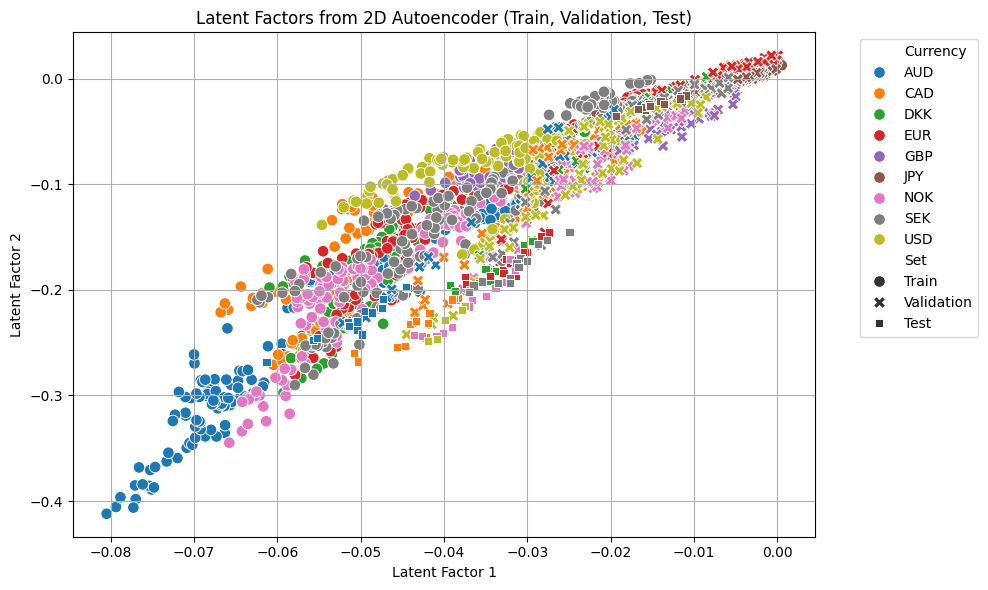

In [89]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']

# Split into sets
train_df = data_full[data_full["Date"].dt.year <= 2018].copy()
val_df = data_full[(data_full["Date"].dt.year > 2018) & (data_full["Date"].dt.year < 2023)].copy()
test_df = data_full[data_full["Date"].dt.year >= 2023].copy()

# Add labels
train_df["Set"] = "Train"
val_df["Set"] = "Validation"
test_df["Set"] = "Test"
combined_df = pd.concat([train_df, val_df, test_df])

# Prepare tensors
data_tensor = torch.tensor(combined_df[maturity_cols].values, dtype=torch.float32)
currencies = combined_df["Currency"].values
sets = combined_df["Set"].values

# Run model to get latent variables
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, predicted_swaps = model(data_tensor)

# Create DataFrame for plotting
latent_df = pd.DataFrame({
    "Latent_1": z[:, 0].detach().numpy(),
    "Latent_2": z[:, 1].detach().numpy(),
    "Currency": currencies,
    "Set": sets
})

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=latent_df, x="Latent_1", y="Latent_2", hue="Currency", style="Set", palette="tab10", s=70)
plt.title("Latent Factors from 2D Autoencoder (Train, Validation, Test)")
plt.xlabel("Latent Factor 1")
plt.ylabel("Latent Factor 2")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

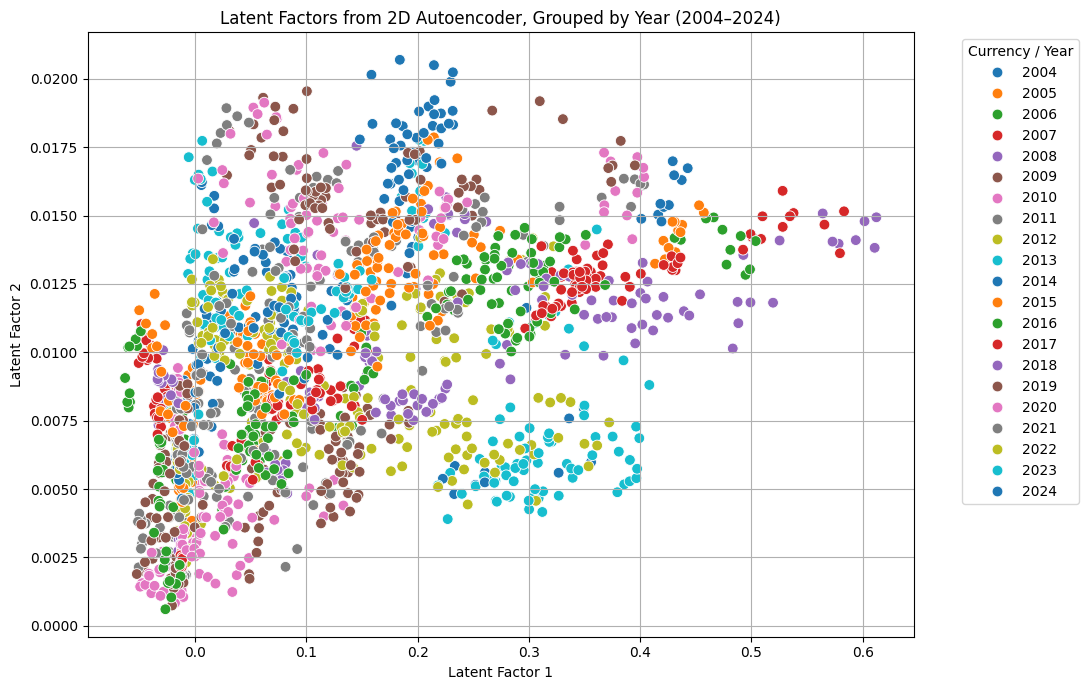

In [85]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year

# Filter to years 2004 to 2024
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# Prepare input tensor
data_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
currencies = data_filtered["Currency"].values
years = data_filtered["Year"].values

# Run model
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, predicted_swaps = model(data_tensor)

# Build dataframe for plotting
latent_df = pd.DataFrame({
    "Latent_1": z[:, 0].detach().numpy(),
    "Latent_2": z[:, 1].detach().numpy(),
    "Currency": currencies,
    "Year": years
})

# Plot
plt.figure(figsize=(11, 7))
sns.scatterplot(data=latent_df, x="Latent_1", y="Latent_2", hue="Year", palette="tab10", s=60)
plt.title("Latent Factors from 2D Autoencoder, Grouped by Year (2004–2024)")
plt.xlabel("Latent Factor 1")
plt.ylabel("Latent Factor 2")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Currency / Year")
plt.tight_layout()
plt.show()

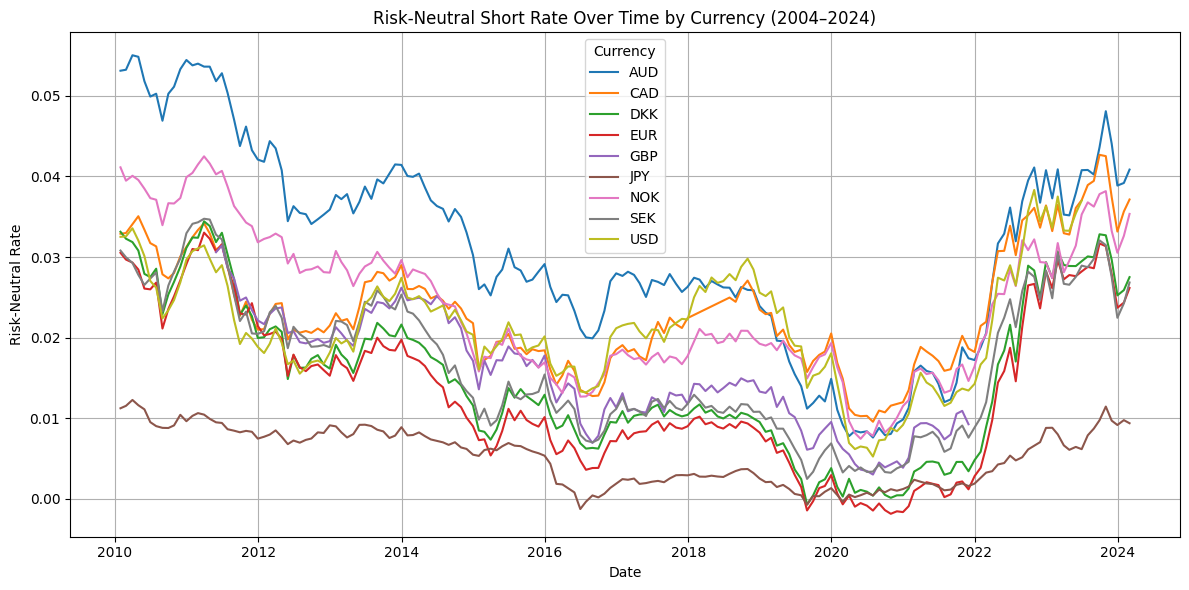

In [51]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load and prepare data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2010, 2024)].copy()

# --- Extract swap rate tensor and metadata ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Run through model all at once ---
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates = model(x_tensor)
short_rates = risk_neutral_rate[:, 0].cpu().detach().numpy() # Take the short rate (maturity 0)

# --- Build DataFrame ---
df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "RiskNeutralRate": short_rates
})

# --- Plot ---
plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_risk_neutral, x="Date", y="RiskNeutralRate", hue="Currency", palette="tab10")
plt.title("Risk-Neutral Short Rate Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel("Risk-Neutral Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

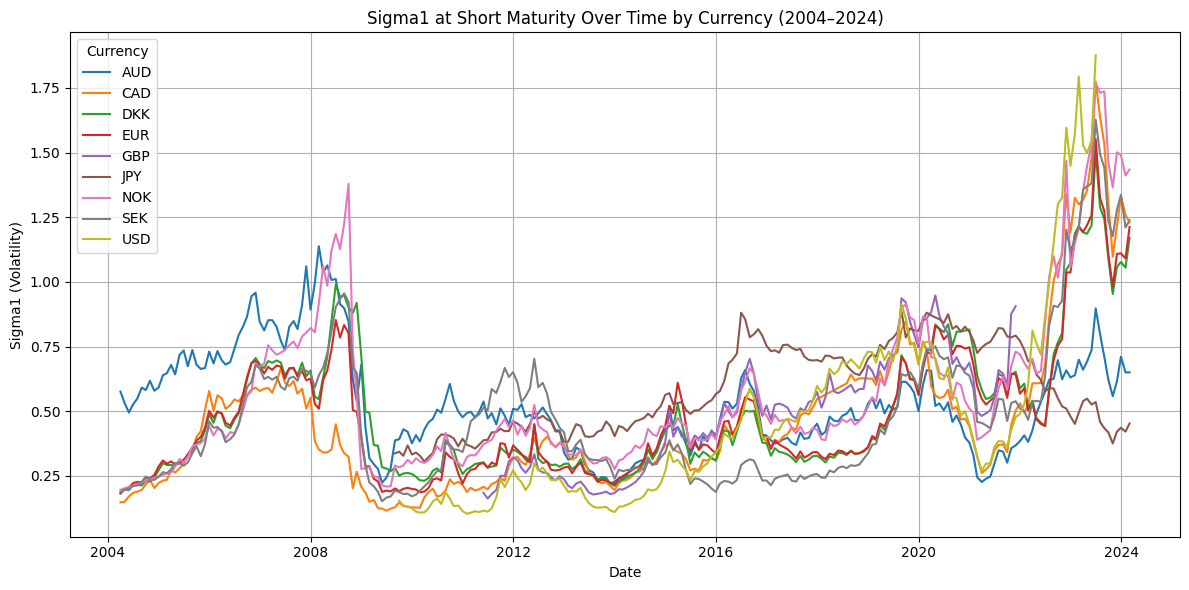

In [27]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load and filter data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Prepare inputs ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Model forward pass (all at once) ---
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, predicted_swaps = model(x_tensor)

# --- Extract sigma1 at maturity = 0 (first column) ---
sigma1_at_short_maturity = sigma1[:, 0].detach().cpu().numpy()

# --- Build DataFrame ---
df_sigma1 = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "Sigma1": sigma1_at_short_maturity
})

# --- Plot ---
plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_sigma1, x="Date", y="Sigma1", hue="Currency", palette="tab10")
plt.title("Sigma1 at Short Maturity Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel("Sigma1 (Volatility)")
plt.grid(True)
plt.tight_layout()
plt.show()

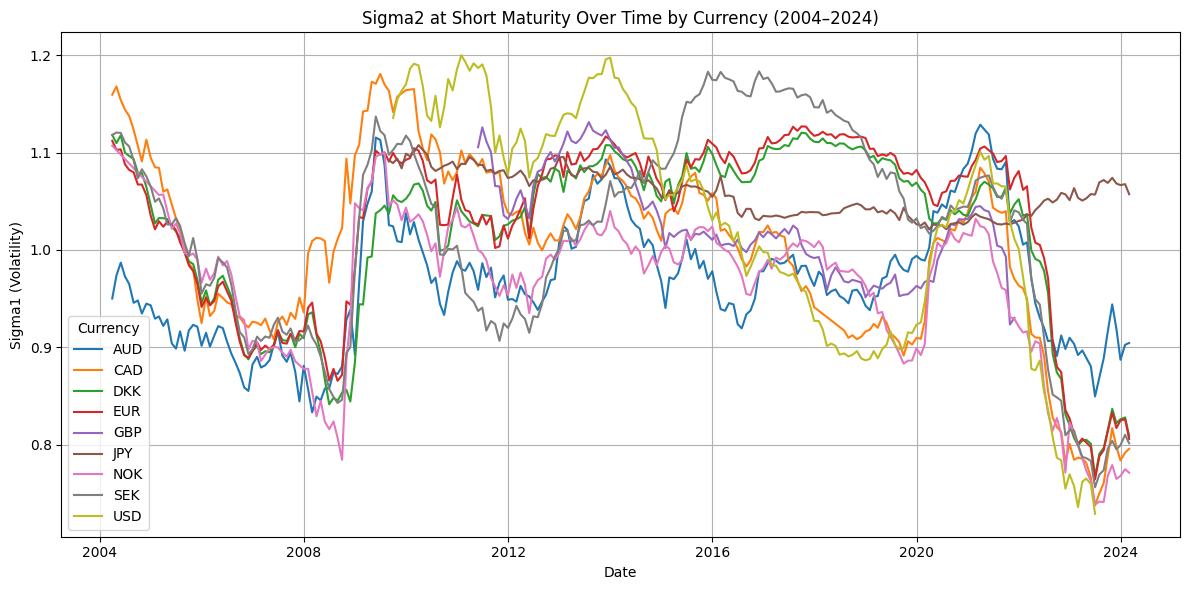

In [28]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load and filter data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Prepare inputs ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Model forward pass (all at once) ---
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, predicted_swaps = model(x_tensor)

# --- Extract sigma1 at maturity = 0 (first column) ---
sigma2_at_short_maturity = sigma2[:, 0].detach().cpu().numpy()

# --- Build DataFrame ---
df_sigma2 = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "Sigma1": sigma2_at_short_maturity
})

# --- Plot ---
plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_sigma2, x="Date", y="Sigma1", hue="Currency", palette="tab10")
plt.title("Sigma2 at Short Maturity Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel("Sigma1 (Volatility)")
plt.grid(True)
plt.tight_layout()
plt.show()

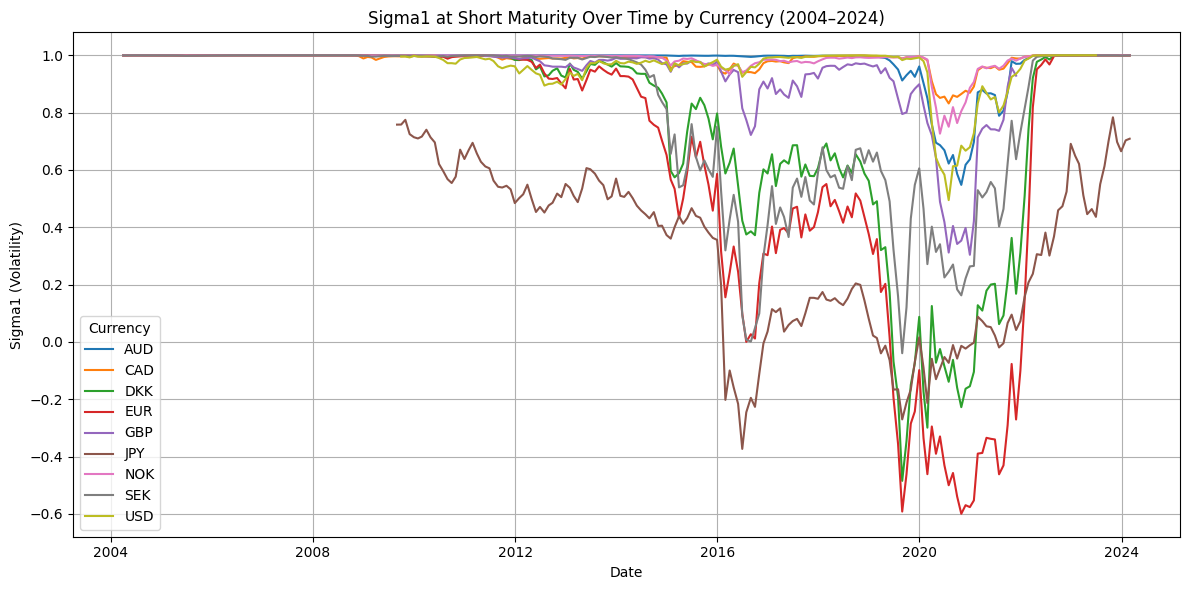

In [29]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load and filter data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Prepare inputs ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Model forward pass (all at once) ---
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, predicted_swaps = model(x_tensor)

# --- Extract sigma1 at maturity = 0 (first column) ---
rho_at_short_maturity = rho1[:, 0].detach().cpu().numpy()

# --- Build DataFrame ---
df_rho = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "Sigma1": rho_at_short_maturity
})

# --- Plot ---
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_rho, x="Date", y="Sigma1", hue="Currency", palette="tab10")
plt.title("Sigma1 at Short Maturity Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel("Sigma1 (Volatility)")
plt.grid(True)
plt.tight_layout()
plt.show()

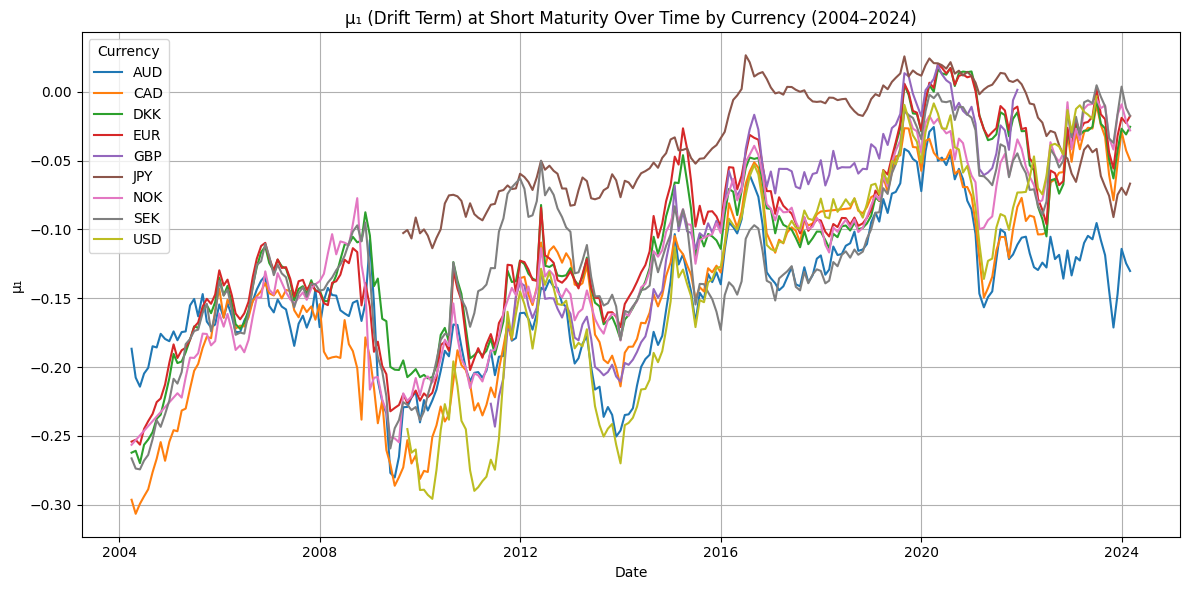

In [30]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load and filter data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Prepare inputs ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Model forward pass (all at once) ---
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, predicted_swaps = model(x_tensor)

# --- Extract μ₁ at t=0 (maturity index 0) ---
mu1_at_short_maturity = mu[:, 0, 0].detach().cpu().numpy()

# --- Build DataFrame ---
df_mu1 = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "Mu1": mu1_at_short_maturity
})

# --- Plot ---
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_mu1, x="Date", y="Mu1", hue="Currency", palette="tab10")
plt.title("μ₁ (Drift Term) at Short Maturity Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel("μ₁")
plt.grid(True)
plt.tight_layout()
plt.show()

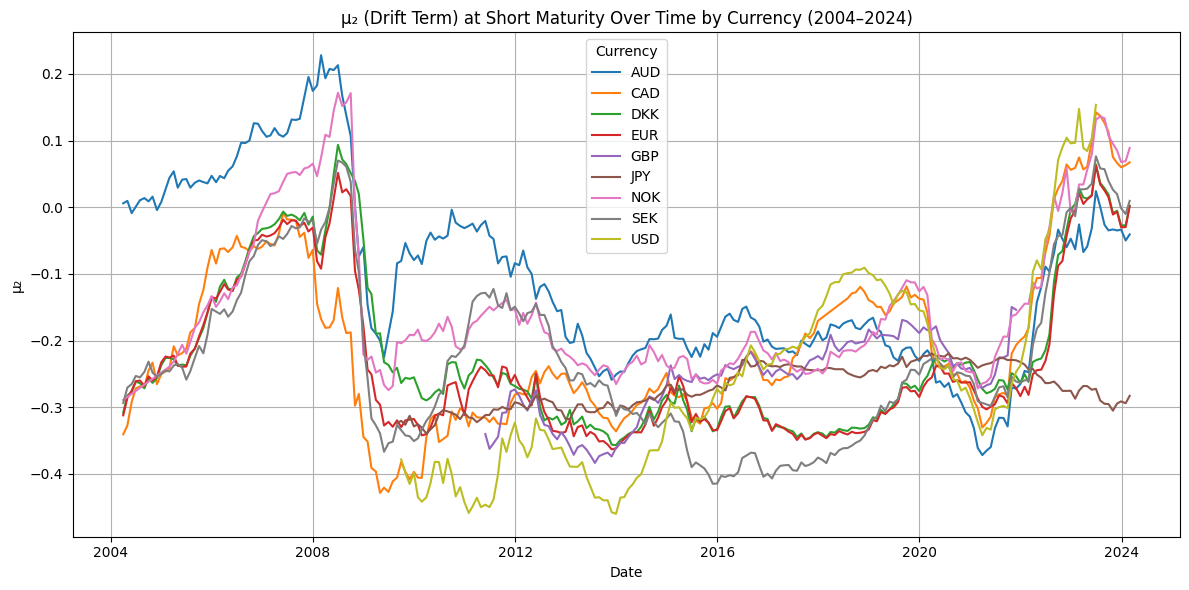

In [31]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load and filter data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Prepare inputs ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Run model ---
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, predicted_swaps = model(x_tensor)

# --- Extract μ₂ at maturity = 0 ---
mu2_at_short_maturity = mu[:, 10, 1].detach().cpu().numpy()

# --- Build DataFrame ---
df_mu2 = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "Mu2": mu2_at_short_maturity
})

# --- Plot ---
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_mu2, x="Date", y="Mu2", hue="Currency", palette="tab10")
plt.title("μ₂ (Drift Term) at Short Maturity Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel("μ₂")
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
# Switch to eval mode
model.eval()

# Forward pass on all training data
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, predicted_swaps = model(train_tensor)

# α, β, γ computation
sigma_H_sigma = torch.matmul(sigma_matrix.transpose(-1, -2), torch.matmul(hessian, sigma_matrix))
trace_sigma_H_sigma = sigma_H_sigma[..., 0, 0] + sigma_H_sigma[..., 1, 1]
alpha = (- gradients_maturities + torch.sum(gradients_latent * mu, dim=2) + 0.5 * trace_sigma_H_sigma) / G_out
beta = risk_neutral_rate / G_out

sigma_grad_outer = torch.matmul(gradients_latent.unsqueeze(-1), gradients_latent.unsqueeze(-2))
gamma_matrix = torch.matmul(sigma_matrix.transpose(-1, -2), torch.matmul(sigma_grad_outer, sigma_matrix))
gamma = 0.5 * (gamma_matrix[..., 0, 0] + gamma_matrix[..., 1, 1])

# B and A
zero_mask = (alpha.abs() < 1e-11)
B_z = beta * maturities
B_nz = (beta / alpha) * (torch.exp(alpha * maturities) - 1)
B = torch.where(zero_mask, B_z, B_nz)
A = gamma * (B ** 2)
gammaB2 = gamma * B ** 2

# Save to disk (optional)
torch.save({'alpha': alpha.cpu(), 'beta': beta.cpu(), 'gamma': gamma.cpu(),
            'B': B.cpu(), 'A': A.cpu(), 'gammaB2': gammaB2.cpu()}, "train_ode_components_torch.pt")

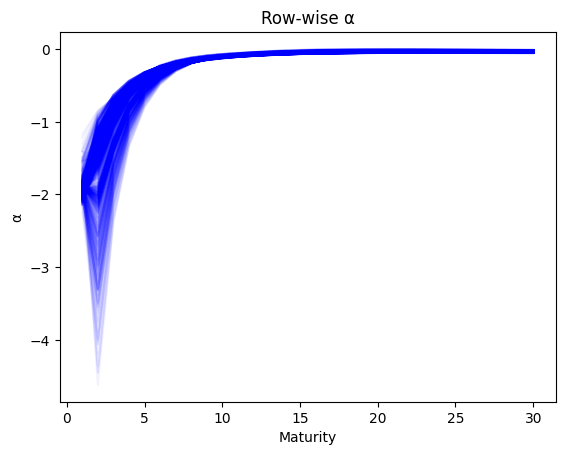

In [52]:
import torch
import matplotlib.pyplot as plt

# Load saved values
components = torch.load("train_ode_components_torch.pt")
alpha = components["alpha"]
beta = components["beta"]
gamma = components["gamma"]
B = components["B"]
A = components["A"]
gammaB2 = components["gammaB2"]

# Plot example: alpha row-wise
for i in range(alpha.shape[0]):
    plt.plot(range(1, 31), alpha.detach()[i], alpha=0.05, color="blue")
plt.title("Row-wise α")
plt.xlabel("Maturity")
plt.ylabel("α")
plt.show()

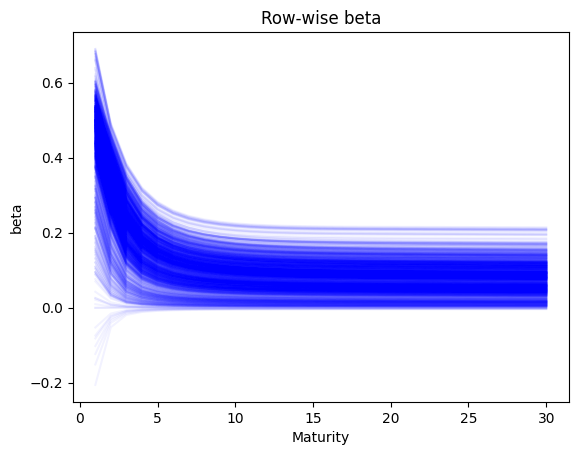

In [53]:
# Plot example: alpha row-wise
for i in range(beta.shape[0]):
    plt.plot(range(1, 31), beta.detach()[i], alpha=0.05, color="blue")
plt.title("Row-wise beta")
plt.xlabel("Maturity")
plt.ylabel("beta")
plt.show()

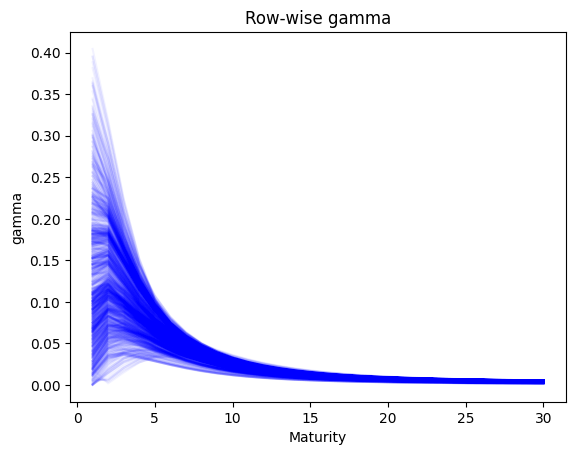

In [54]:
# Plot example: alpha row-wise
for i in range(gamma.shape[0]):
    plt.plot(range(1, 31), gamma.detach()[i], alpha=0.05, color="blue")
plt.title("Row-wise gamma")
plt.xlabel("Maturity")
plt.ylabel("gamma")
plt.show()

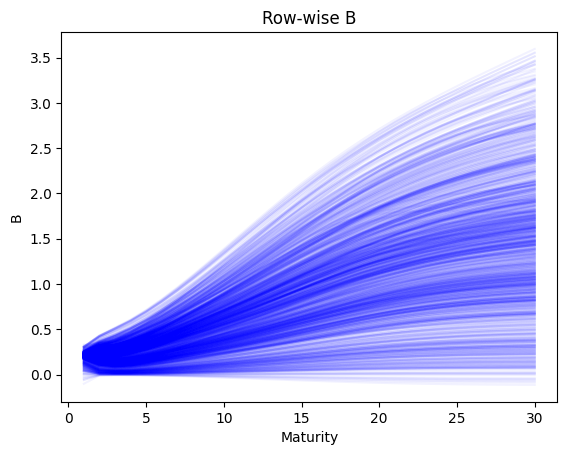

In [55]:
# Plot example: alpha row-wise
for i in range(B.shape[0]):
    plt.plot(range(1, 31), B.detach()[i], alpha=0.05, color="blue")
plt.title("Row-wise B")
plt.xlabel("Maturity")
plt.ylabel("B")
plt.show()

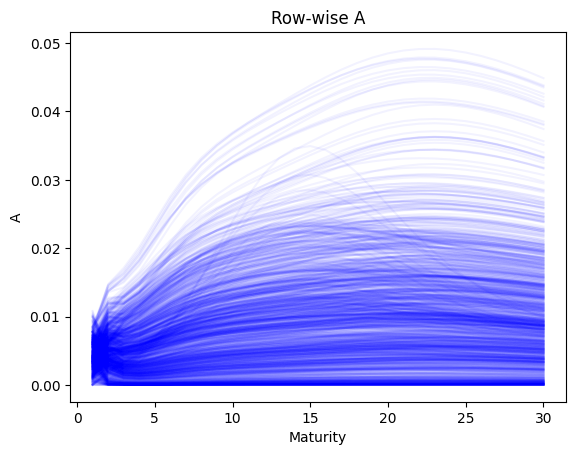

In [56]:
# Plot example: alpha row-wise
for i in range(A.shape[0]):
    plt.plot(range(1, 31), A.detach()[i], alpha=0.05, color="blue")
plt.title("Row-wise A")
plt.xlabel("Maturity")
plt.ylabel("A")
plt.show()

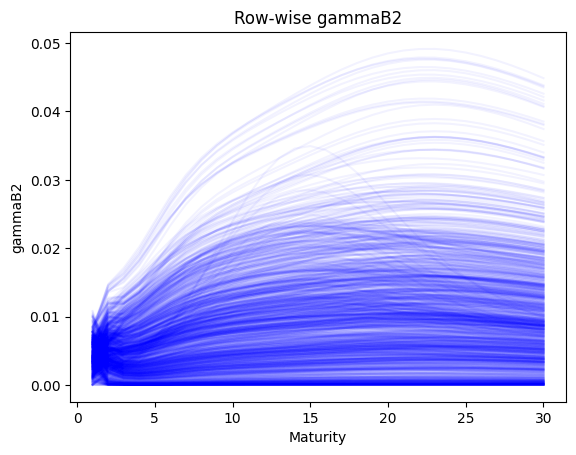

In [57]:
# Plot example: alpha row-wise
for i in range(gammaB2.shape[0]):
    plt.plot(range(1, 31), gammaB2.detach()[i], alpha=0.05, color="blue")
plt.title("Row-wise gammaB2")
plt.xlabel("Maturity")
plt.ylabel("gammaB2")
plt.show()